# 2017년 코트라 데이터 분석 

안녕하세요. <br>

저희는 2018년 데이터 분석 및 모델링을 통해 가장 낮은 `RMSE`를 찾으며 분석과 모델링을 바탕으로 2019년 수입금액을 예측하였습니다.
<br>


기존의 제공된 데이터 외에 다양한 외부 데이터를 수집하여 분석에 예측을 높이기 위해 노력하였습니다.<br>

모델링의 경우 `배깅(bagging)`과 `부스팅(boosting)`을 통해 변수를 선정하며 `A/B 테스트`를 통해 최적의 변수를 선정하였습니다. 모델의 일반화 성능을 높이기 위해 `랜덤 포레스트(RandomForest)`를 주 모델로 선정하였습니다. 


## 기존 데이터의 분포를 확인 후 모델링의 필요한 변수 선정 및 외부 데이터 변수 만들기



## INDEX


### 1. 모듈 및 데이터 로드

### 2. 데이터 시각화 및 인사이트 도출
#### 2.1 탐색적 데이터 분석

각 변수들간의 관계를 확인하기

#### 2.2이상치 탐색 및 노이즈 제거

데이터 누수를 막기 위한 이상치 탐색 및 제거 
#### 3. 데이터 전처리 -기존 변수
3.1 NY_GDP_MKTP_CD - GDP  변수
- - `연간 GDP 변화율` :(NY_GDP_MKTP_CD - NY_GDP_MKTP_CD_1Y)/NY_GDP_MKTP_CD_1Y
- - `1인당 GDP` : NY_GDP_MKTP_CD - GDP  / SP_POP_TOTL
3.2 TRADE_COUNTRYCD-변수 이용
- -`품목별 무역 의존도`: 해당 연도 해당 구각의 해당 품목 수입금액/ 해당 연도 해당 국가의 전체 품목 수입금액
3.3 TRADE_HSCD 해당 연도 해당 품목 전세계 총 수입금액
- -`나라별 무역 의존도`: 해당 연도 해당 국가의 해당 품목 수입금액/ 해당 연도 해당 품목의전세계 총 수입금액
3.4 TARIFF_AVG
- -해당 국가에서 해당 품목에 적용되는 평균 관세율은 그대로
3.5 SNDIST
- -해당 국가와 수입 국가 간 평균 거리 
- -파생변수
- -`품목별 평균 거리` = 품목별로 SNDIST의 평균을 구한다. 
- -`품목별 평균 거리당` 수익 =TRADE_HSCD_COUNTRYCD/SNDIST

3_6  COUNTRYNM -영문국가명
- -`무역 경제권별로 정리해서 전처리`

#### 4. 데이터 전처리 – 외부 데이터
- -나라별 컨테이너 수출실적 2017~2019
- -우리나라 항만 컨테이너 물동량 
- -lpi = 물류성과지표 2016은 2017년 데이터 사용 , 2018은 2018년 데이터에 사용
- -fl =항공화물운송량
- -협력제 =경제권 협력체들 정리

4.1 품목별 변수 추가 
- -기존 2017년 모델링 과정에서 품목변수의 중요성 확인
- -추가로 기초 통계량 및 비율 변수 추가
- -품목별 `TRADE_HSCD_COUNTRYCD, TARIFF_AVG 변수 합, 평균,비율 변수`
- -`HSCD -HS Code` (품목코드) 변수 정리
- -상위 5개 `HSCD 원핫` 인코딩 정리

5.최종 데이터 프레임 정리 완료

In [35]:
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#내부에 결과를 출력하도록 설정

%matplotlib inline 

#시각화 한글 폰트 설정
#맥 사용자
plt.rc('font', family ='AppleGothic')

#마이너스 기호 출력
plt.rc('axes', unicode_minus=False)

#분석에 문제가 없는 경고 메세지는 숨긴다.
import warnings 
warnings.filterwarnings('ignore')

In [36]:
train = pd.read_csv('공모전데이터_분석용_KOTRA_0525.csv')
test = pd.read_csv('공모전데이터_예측용_KOTRA_0525.csv')

In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21189 entries, 0 to 21188
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UNC_YEAR                 21189 non-null  int64  
 1   HSCD                     21189 non-null  int64  
 2   COUNTRYCD                21189 non-null  int64  
 3   COUNTRYNM                21189 non-null  object 
 4   TRADE_COUNTRYCD          21189 non-null  int64  
 5   TRADE_HSCD               21189 non-null  int64  
 6   TARIFF_AVG               21060 non-null  float64
 7   SNDIST                   21167 non-null  float64
 8   NY_GDP_MKTP_CD           21189 non-null  int64  
 9   NY_GDP_MKTP_CD_1Y        21189 non-null  int64  
 10  SP_POP_TOTL              21189 non-null  int64  
 11  PA_NUS_FCRF              17701 non-null  float64
 12  IC_BUS_EASE_DFRN_DB      21189 non-null  float64
 13  KMDIST                   21189 non-null  float64
 14  TRADE_HSCD_COUNTRYCD  

In [38]:
test.describe()

,UNC_YEAR,HSCD,COUNTRYCD,TRADE_COUNTRYCD,TRADE_HSCD,TARIFF_AVG,SNDIST,NY_GDP_MKTP_CD,NY_GDP_MKTP_CD_1Y,SP_POP_TOTL,PA_NUS_FCRF,IC_BUS_EASE_DFRN_DB,KMDIST,TRADE_HSCD_COUNTRYCD,KR_TRADE_HSCD_COUNTRYCD
count,21189.0,21189.000000,21189.00000,2.118900e+04,2.118900e+04,20564.000000,21186.000000,2.118900e+04,2.118900e+04,2.118900e+04,17701.000000,21189.000000,21189.000000,2.118600e+04,0.0
mean,2018.0,736897.468120,450.41111,3.843218e+11,1.704633e+10,4.389127,6421.839852,1.750770e+12,1.644687e+12,1.234797e+08,1449.668518,71.336974,7951.616743,3.369806e+08,NaN
std,0.0,201427.725252,254.19937,5.210679e+11,4.529307e+10,8.426212,2571.515373,3.685611e+12,3.433912e+12,2.865277e+08,4687.373483,10.304985,4054.057558,2.377977e+09,NaN
min,2018.0,190219.000000,12.00000,6.125977e+09,3.012275e+08,0.000000,1058.383504,1.310877e+10,1.142576e+10,3.170208e+06,0.283583,42.974820,955.651062,4.145000e+03,NaN
25%,2018.0,640419.000000,203.00000,9.282130e+10,2.802883e+09,0.000000,4333.182133,2.497130e+11,2.357337e+11,1.142705e+07,1.903768,65.204853,4692.671875,1.146273e+07,NaN
50%,2018.0,843131.000000,458.00000,2.343949e+11,5.417171e+09,1.500000,5635.271340,4.550949e+11,4.453453e+11,3.797475e+07,6.870325,73.429480,8262.062500,4.459327e+07,NaN
75%,2018.0,853329.000000,699.00000,4.734418e+11,1.334556e+10,5.000000,8000.268487,1.669583e+12,1.574199e+12,9.554040e+07,97.595658,78.772040,9954.009766,1.587431e+08,NaN
max,2018.0,999999.000000,842.00000,2.629608e+12,4.810890e+11,504.900000,15313.671040,2.058016e+13,1.951935e+13,1.392730e+09,20933.416670,87.022130,18375.181640,1.274310e+11,NaN


## 데이터 시각화를 통한 탐색적 분석

In [39]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

#내부에 결과를 출력하도록 설정

%matplotlib inline 

#시각화 한글 폰트 설정
#맥 사용자
plt.rc('font', family ='AppleGothic')

#마이너스 기호 출력
plt.rc('axes', unicode_minus=False)

#분석에 문제가 없는 경고 메세지는 숨긴다.
import warnings 
warnings.filterwarnings('ignore')

In [40]:
#학습 데이터 복사본 생성
traindata = train.copy()

# 1. 탐색적 데이터 분석

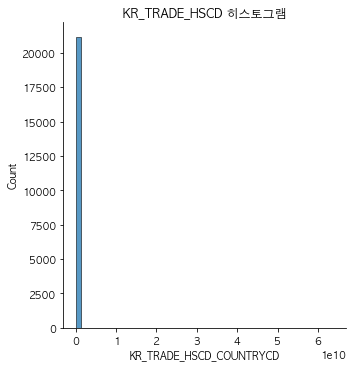

In [41]:
#타깃 변수(KR_TRADE_HSCD) 분포 시각화
sns.displot(traindata['KR_TRADE_HSCD_COUNTRYCD'], kde= False, bins=50)
plt.title("KR_TRADE_HSCD 히스토그램")#그래프 제목 설정
plt.show()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

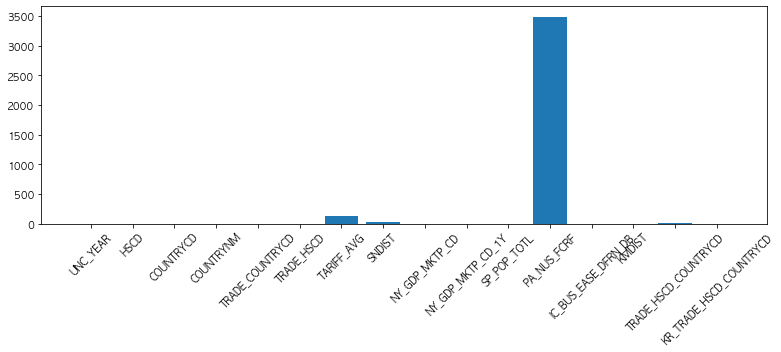

In [42]:
#결측치가 존재하는 칼럼 찾기
plt.figure(figsize =(13,4))
plt.bar(train.columns, train.isnull().sum())
plt.xticks(rotation=45)

<AxesSubplot:xlabel='KR_TRADE_HSCD_COUNTRYCD'>

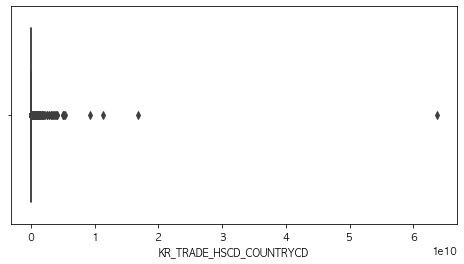

In [43]:
#KR_TRADE_HSCD_COUNTRYCD에 대한 이상치의 존재 확인

plt.figure(figsize=(8,4))
sns.boxplot(train['KR_TRADE_HSCD_COUNTRYCD'])

<AxesSubplot:xlabel='TRADE_HSCD_COUNTRYCD'>

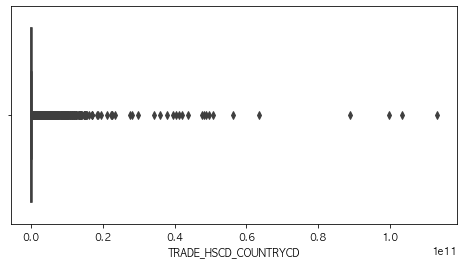

In [44]:
#TRADE_HSCD_COUNTRYCD에 대한 이상치의 존재 확인

plt.figure(figsize=(8,4))
sns.boxplot(train['TRADE_HSCD_COUNTRYCD'])

In [45]:
#매출액이 0 이상인 행 출력
train[train['KR_TRADE_HSCD_COUNTRYCD']>0]

,UNC_YEAR,HSCD,COUNTRYCD,COUNTRYNM,TRADE_COUNTRYCD,TRADE_HSCD,TARIFF_AVG,SNDIST,NY_GDP_MKTP_CD,NY_GDP_MKTP_CD_1Y,SP_POP_TOTL,PA_NUS_FCRF,IC_BUS_EASE_DFRN_DB,KMDIST,TRADE_HSCD_COUNTRYCD,KR_TRADE_HSCD_COUNTRYCD
0,2017,190590,12,Algeria,46052990973,19480986257,30.0,3878.238437,170163165961,159994837855,41389198,110.973017,46.109810,9954.009766,3.416326e+06,7657
1,2017,190590,36,Australia,228441691195,19480986257,0.0,12203.155980,1329188475752,1208846993740,24601860,1.304758,80.223690,8329.652344,4.387470e+08,5294788
2,2017,190590,40,Austria,166475020975,19480986257,0.0,4403.247293,417237869116,395568644341,8797566,NaN,78.856460,8289.029297,4.532064e+08,335818
3,2017,190590,56,Belgium,406412223480,19480986257,0.0,3980.375563,502698069367,475739588765,11375158,NaN,72.409200,8722.114258,7.065245e+08,173709
4,2017,190590,76,Brazil,150749493921,19480986257,18.0,9644.206941,2062831045936,1795700168991,207833831,3.191389,55.382403,18364.505860,3.132965e+07,122850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21184,2017,852852,784,United Arab Emirates,270954907547,18327708223,NaN,5643.250737,385605506855,357045064670,9487203,3.672500,77.434350,6909.236328,2.056493e+08,881214
21185,2017,852852,792,Turkey,233799651234,18327708223,NaN,4123.461111,858988610574,869683121563,81101892,3.648133,69.378820,7967.700684,1.330809e+08,9545535
21186,2017,852852,818,Egypt,66338749061,18327708223,NaN,NaN,235733695652,332441717791,96442593,17.782534,55.474280,8497.368164,NaN,1313545
21187,2017,852852,826,United Kingdom,641332371112,18327708223,NaN,4071.487776,2666229179958,2694283209613,66058859,0.776977,83.341080,8875.389648,1.142794e+09,19876811


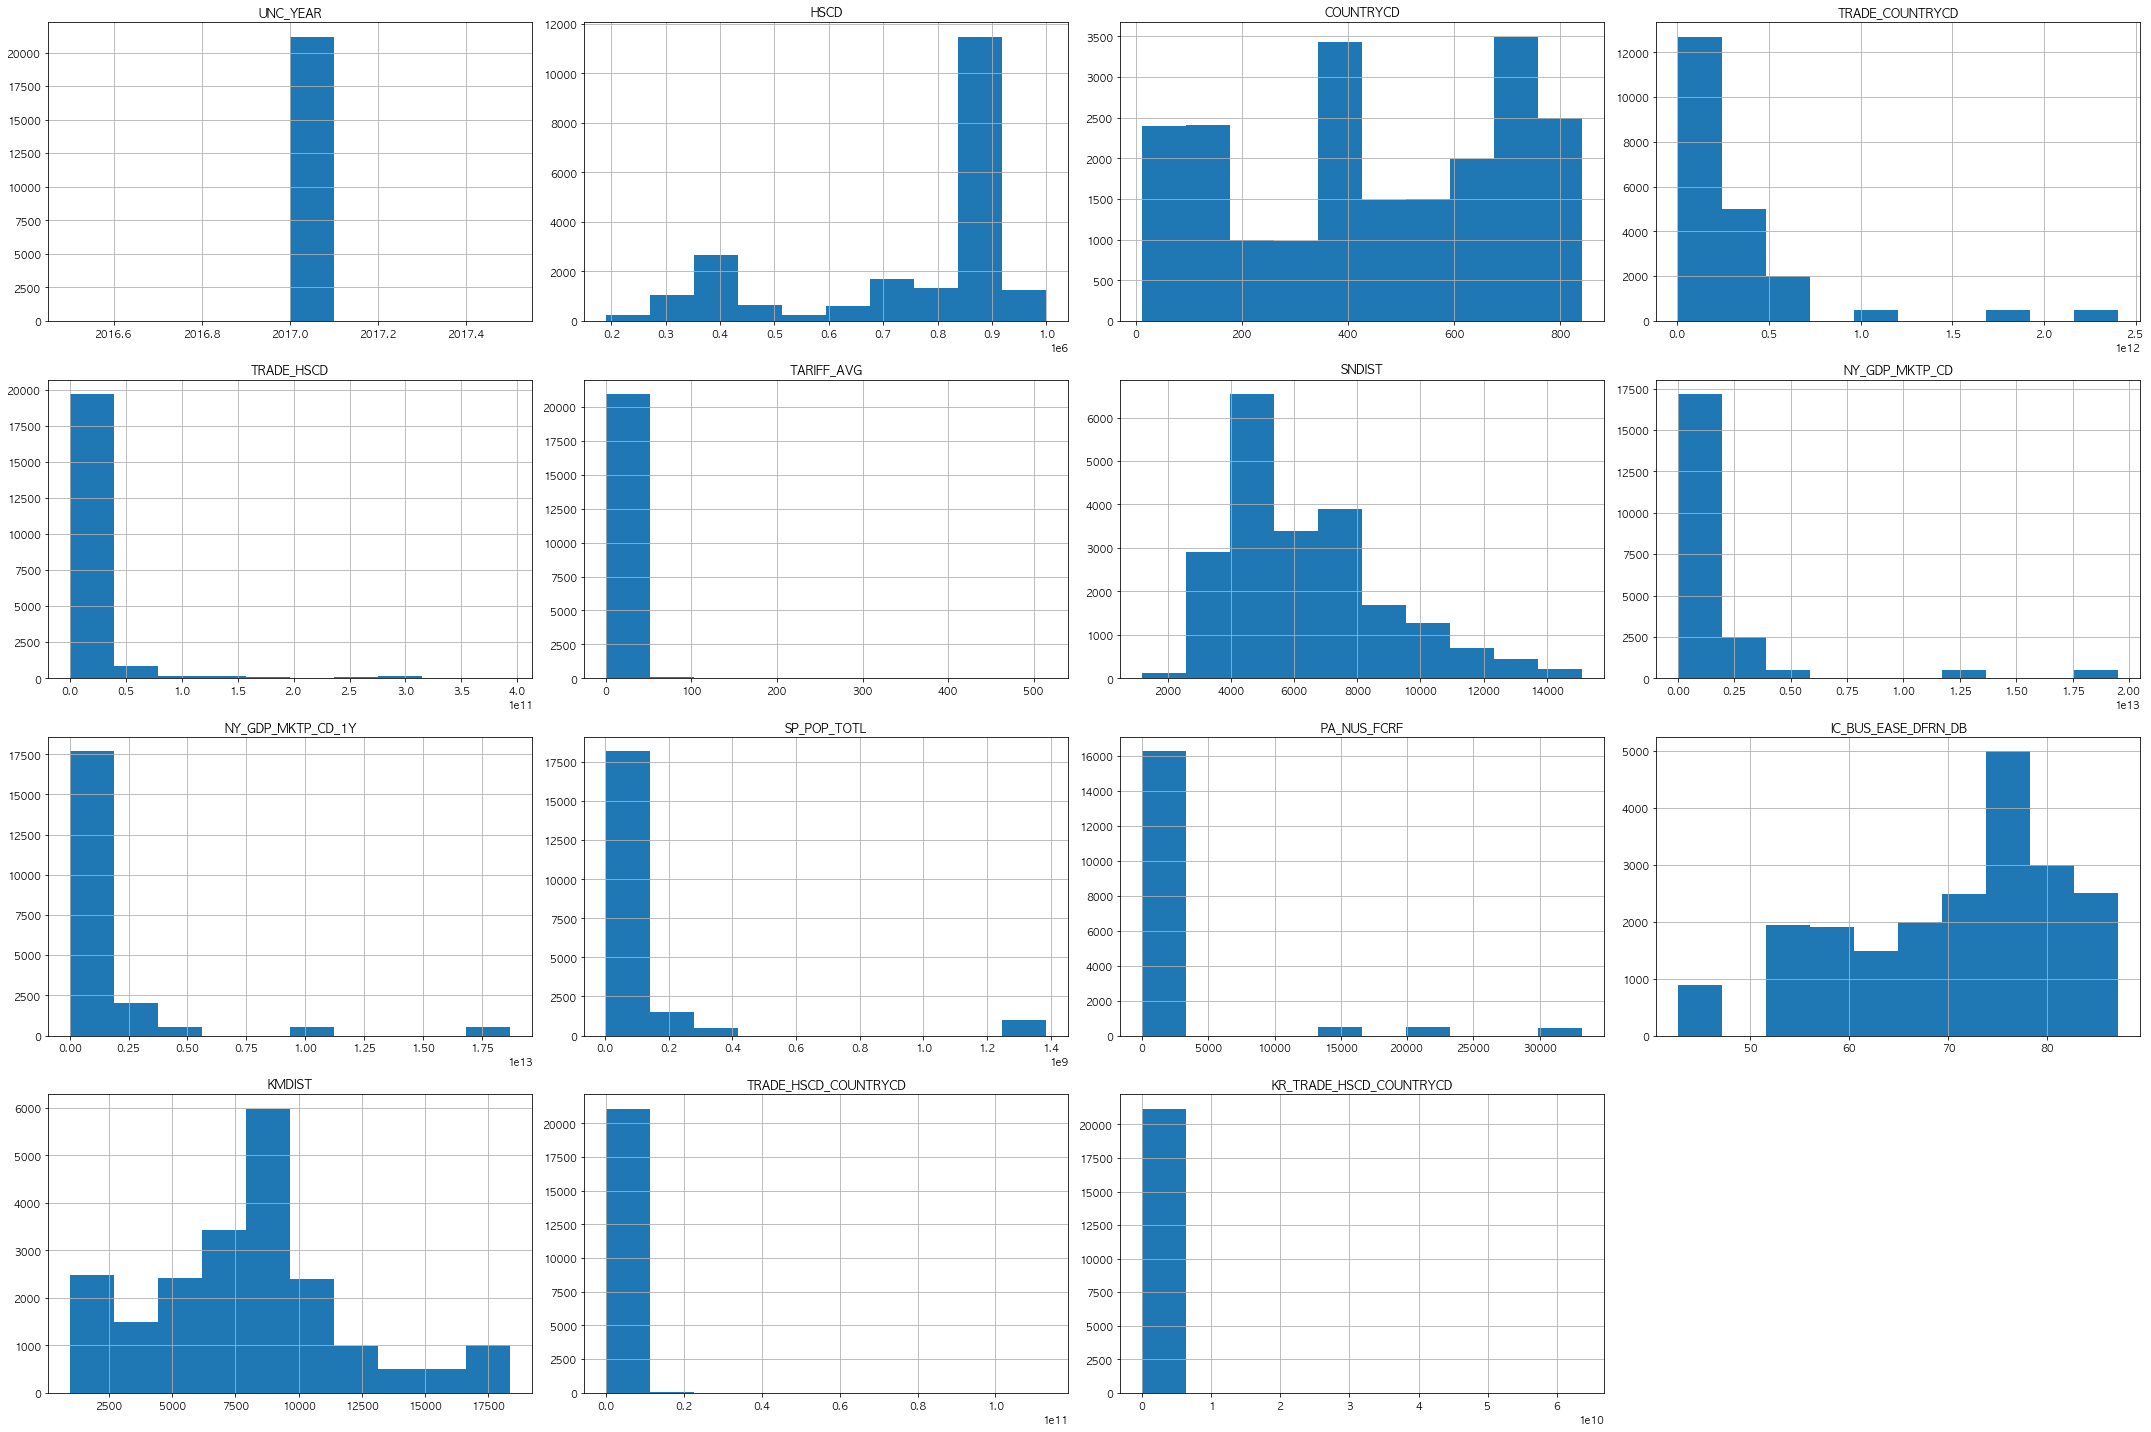

In [14]:
#변수 생성 및 시각화
train.hist(figsize=(30,20))
plt.tight_layout()
plt.show()

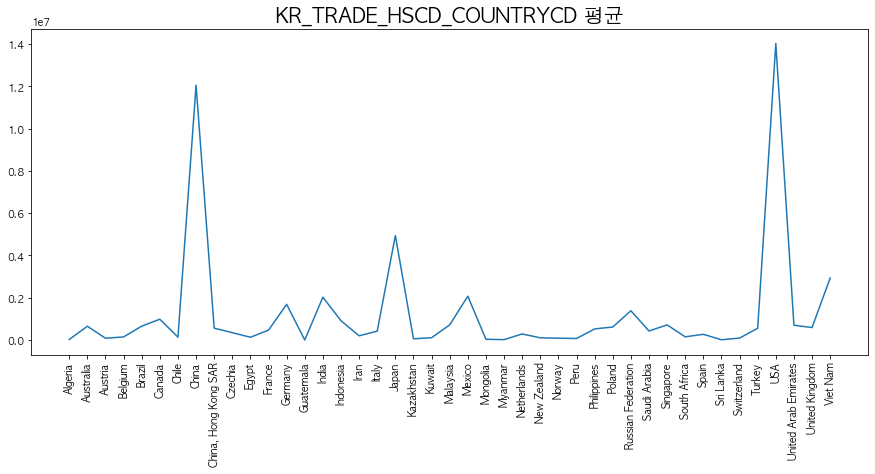

In [48]:
#한국으로 부터 수입한 내용 
plt.figure(figsize=(15,6))
plt.plot(train.groupby('COUNTRYNM')['KR_TRADE_HSCD_COUNTRYCD'].median())
plt.title('KR_TRADE_HSCD_COUNTRYCD 평균',size=20)
plt.xticks(rotation='vertical')

plt.show()

- 한국으로부터 수입한 국가 높은 순위 
- USA, China, Japan, Mexico, India, Germany, viet Nam,Russian Federation, Singapore.

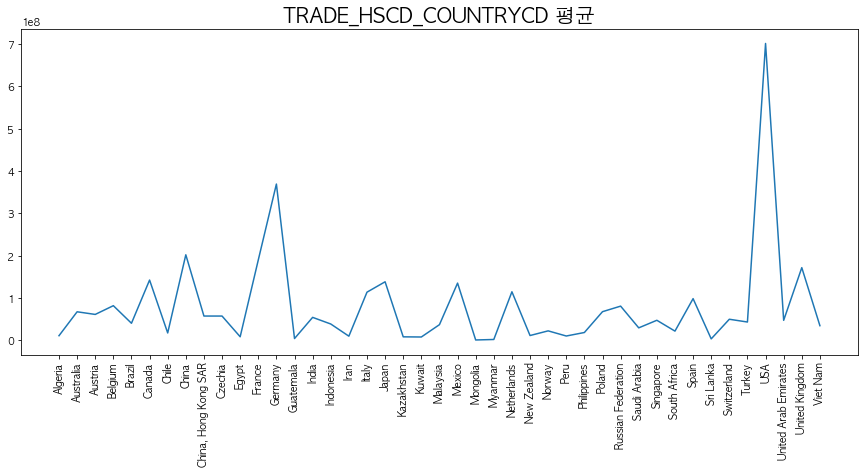

In [49]:
plt.figure(figsize=(15,6))
plt.plot(train.groupby('COUNTRYNM')['TRADE_HSCD_COUNTRYCD'].median())
plt.title('TRADE_HSCD_COUNTRYCD 평균',size=20)
plt.xticks(rotation='vertical')

plt.show()

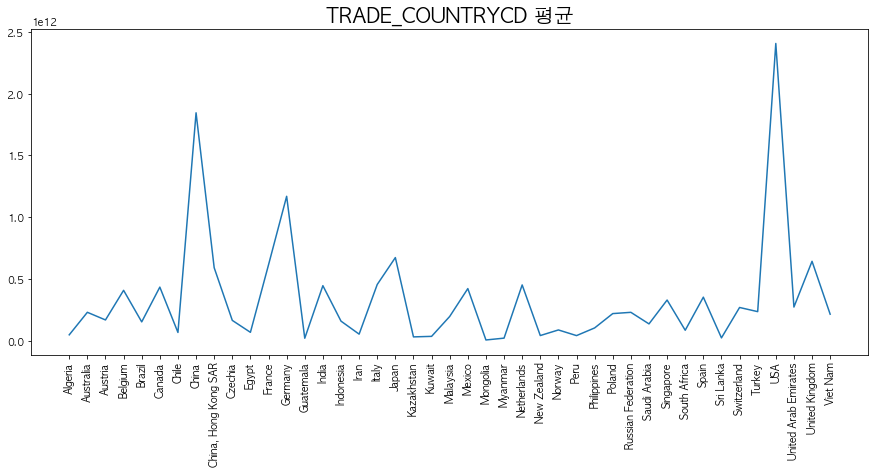

In [50]:
plt.figure(figsize=(15,6))
plt.plot(train.groupby('COUNTRYNM')['TRADE_COUNTRYCD'].median())
plt.title('TRADE_COUNTRYCD 평균',size=20)
plt.xticks(rotation='vertical')

plt.show()

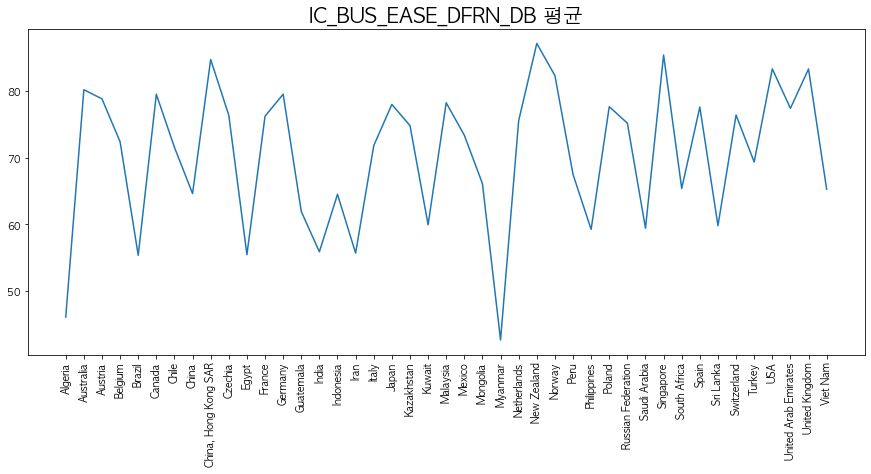

In [51]:
plt.figure(figsize=(15,6))
plt.plot(train.groupby('COUNTRYNM')['IC_BUS_EASE_DFRN_DB'].median())
plt.title('IC_BUS_EASE_DFRN_DB 평균',size=20)
plt.xticks(rotation='vertical')

plt.show()

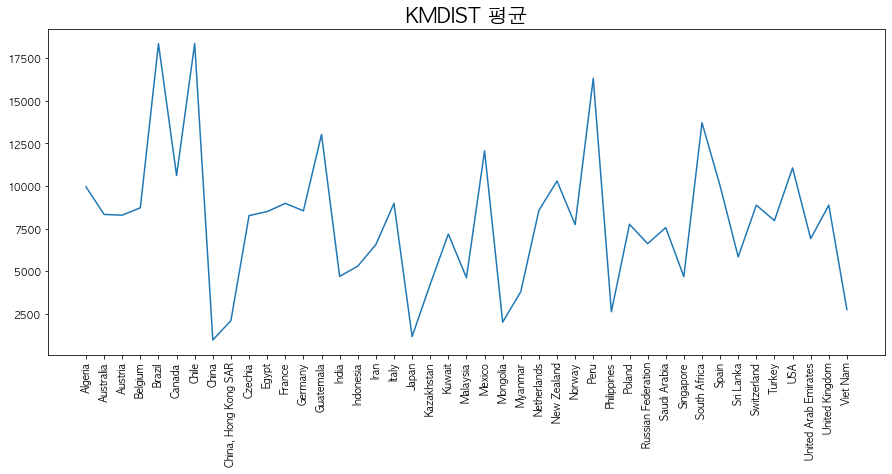

In [52]:
plt.figure(figsize=(15,6))
plt.plot(train.groupby('COUNTRYNM')['KMDIST'].median())
plt.title('KMDIST 평균',size=20)
plt.xticks(rotation='vertical')

plt.show()

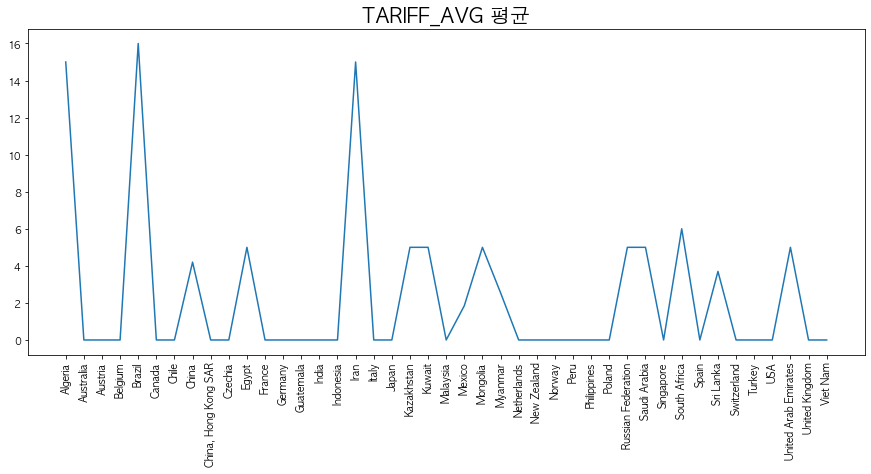

In [53]:
plt.figure(figsize=(15,6))
plt.plot(train.groupby('COUNTRYNM')['TARIFF_AVG'].median())
plt.title('TARIFF_AVG 평균',size=20)
plt.xticks(rotation='vertical')

plt.show()

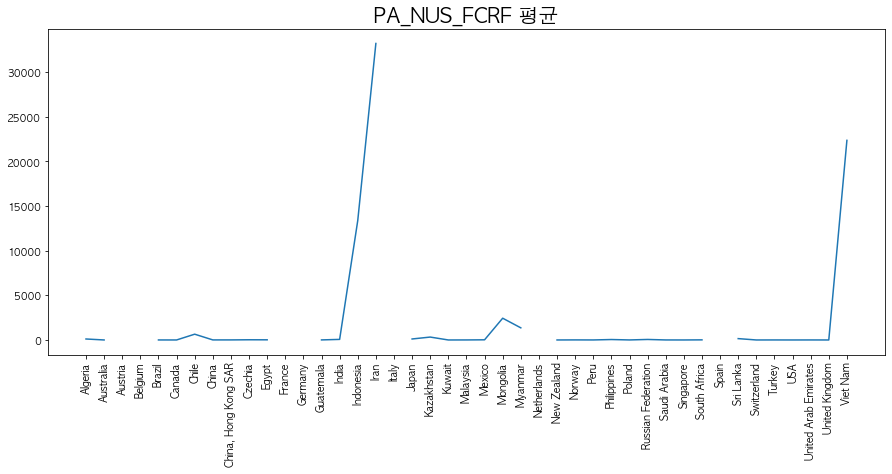

In [54]:
plt.figure(figsize=(15,6))
plt.plot(train.groupby('COUNTRYNM')['PA_NUS_FCRF'].median())
plt.title('PA_NUS_FCRF 평균',size=20)
plt.xticks(rotation='vertical')

plt.show()

In [55]:
sns.barplot(data=usa, x="TARIFF_AVG", y="KR_TRADE_HSCD_COUNTRYCD")

NameError: name 'usa' is not defined

In [56]:
#타깃 변수(KR_TRADE_HSCD)분포 확인
traindata.groupby('KR_TRADE_HSCD_COUNTRYCD').size().head(10)
#0값도 존재 확인 

KR_TRADE_HSCD_COUNTRYCD
0    343
1      3
2      6
3      2
4      1
5      1
6      1
7      2
8      3
9      3
dtype: int64

### 해당국가 해당품목 수입금액과 비즈니스 용이성 관계

In [57]:
#KR_TRADE_HSCD_COUNTRYCD와 IC_BUS_EASE_DFRN_DB의 관계
t_mean=(traindata.groupby('COUNTRYNM')['KR_TRADE_HSCD_COUNTRYCD'].
      mean().
      reset_index().
      rename(columns={'KR_TRADE_HSCD_COUNTRYCD':'KR_mean'}))

b_mean=(traindata.groupby('COUNTRYNM')['IC_BUS_EASE_DFRN_DB'].
      mean().
      reset_index().
      rename(columns={'IC_BUS_EASE_DFRN_DB':'ICB_mean'}))

df = pd.merge(t_mean, b_mean, how='inner', on='COUNTRYNM')

df

,COUNTRYNM,KR_mean,ICB_mean
0,Algeria,1.806496e+06,46.109810
1,Australia,1.590653e+07,80.223690
2,Austria,1.551196e+06,78.856460
3,Belgium,3.096248e+06,72.409200
4,Brazil,8.519652e+06,55.382403
5,Canada,1.067096e+07,79.540940
6,Chile,2.992454e+06,71.581850
7,China,2.638022e+08,64.639360
8,"China, Hong Kong SAR",6.304216e+07,84.760590
9,Czechia,7.224613e+06,76.388340


           KR_mean  ICB_mean
KR_mean   1.000000  0.070353
ICB_mean  0.070353  1.000000


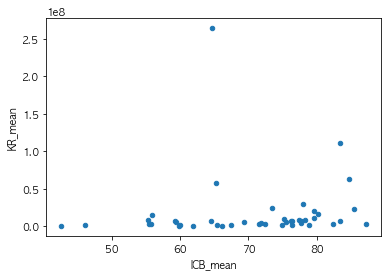

In [58]:
df.plot(kind='scatter',x='ICB_mean' ,y='KR_mean')
print(df.corr())

- KR_mean이 높아질수록 ICB_mean 큰 경향은 찾기 어려움
- 상관성도 0.070353 낮은 편임

### 한국과의 거리와 해당연도 수입액 관계

In [59]:
#TRADE_HSCD_COUNTRYCD와 IC_BUS_EASE_DFRN_DB의 관계
t_mean=(traindata.groupby('COUNTRYNM')['KR_TRADE_HSCD_COUNTRYCD'].
      mean().
      reset_index().
      rename(columns={'KR_TRADE_HSCD_COUNTRYCD':'THC_mean'}))

k_mean=(traindata.groupby('COUNTRYNM')['KMDIST'].
      mean().
      reset_index().
      rename(columns={'KMDIST':'k_mean'}))

df_1 = pd.merge(t_mean, k_mean, how='inner', on='COUNTRYNM')

df_1

,COUNTRYNM,THC_mean,k_mean
0,Algeria,1.806496e+06,9954.009766
1,Australia,1.590653e+07,8329.652344
2,Austria,1.551196e+06,8289.029297
3,Belgium,3.096248e+06,8722.114258
4,Brazil,8.519652e+06,18364.505860
5,Canada,1.067096e+07,10617.703130
6,Chile,2.992454e+06,18375.181640
7,China,2.638022e+08,955.651062
8,"China, Hong Kong SAR",6.304216e+07,2095.842529
9,Czechia,7.224613e+06,8262.062500


          THC_mean    k_mean
THC_mean  1.000000 -0.304067
k_mean   -0.304067  1.000000


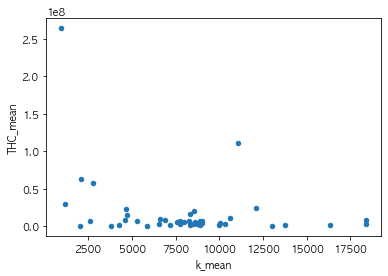

In [60]:
df_1.plot(kind='scatter',x='k_mean' ,y='THC_mean')
print(df_1.corr())

- 한국과 가까군 지역과 해당 국가 수입금액의 차이는 큰 영향이 없으며
- 상관계수도 -0.30406으로 낮은 수치 

### 해당 연도 해당 국가의 해당 품목 수입금액과 내년 해당 국가가 해당 품목을 한국으로부터 수입한 금액과의 관계

In [61]:
#TRADE_HSCD_COUNTRYCD와 KR_TRADE_HSCD_COUNTRYCD의 관계
t_mean=(traindata.groupby('COUNTRYNM')['KR_TRADE_HSCD_COUNTRYCD'].
      mean().
      reset_index().
      rename(columns={'KR_TRADE_HSCD_COUNTRYCD':'KR_mean'}))

k_mean=(traindata.groupby('COUNTRYNM')['TRADE_HSCD_COUNTRYCD'].
      mean().
      reset_index().
      rename(columns={'TRADE_HSCD_COUNTRYCD':'TH_mean'}))

df_2 = pd.merge(t_mean, k_mean, how='inner', on='COUNTRYNM')

df_2

,COUNTRYNM,KR_mean,TH_mean
0,Algeria,1.806496e+06,3.641808e+07
1,Australia,1.590653e+07,2.408986e+08
2,Austria,1.551196e+06,1.411000e+08
3,Belgium,3.096248e+06,3.090162e+08
4,Brazil,8.519652e+06,1.294128e+08
5,Canada,1.067096e+07,4.096340e+08
6,Chile,2.992454e+06,5.762337e+07
7,China,2.638022e+08,1.497527e+09
8,"China, Hong Kong SAR",6.304216e+07,7.671685e+08
9,Czechia,7.224613e+06,1.868557e+08


          KR_mean   TH_mean
KR_mean  1.000000  0.716435
TH_mean  0.716435  1.000000


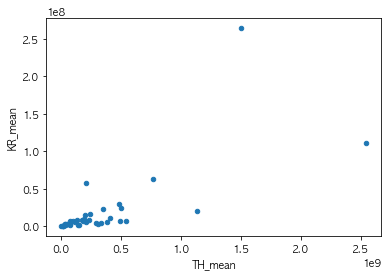

In [62]:
df_2.plot(kind='scatter',x='TH_mean' ,y='KR_mean')
print(df_2.corr())

- 해당국가 해당품목 수입금액이 증가할수록 내년 해당 국가의 해당품목 한국 수입액이 증가하는 경향
- 상관계수 0.716435으로 상대적으로 높은 양의 상관 

## 2.2. 이상치 탐색 및 노이즈 제거

In [63]:
#예측값이 0은 제외하고 학습
train =train[train['KR_TRADE_HSCD_COUNTRYCD']>0]

In [64]:
#학습 데이터 복사본 생성
train = train.copy()

In [65]:
#TRADE_HSCD_COUNTRYCD 이상치를 탐색을 위한 수치 정의
Q1 = train['TRADE_HSCD_COUNTRYCD'].quantile(0.25)
Q3 = train['TRADE_HSCD_COUNTRYCD'].quantile(0.75)
IQR = Q3-Q1


#실제 TRADE_HSCD_COUNTRYCD 이상치 탐색
df_outlier= train.loc[(train['TRADE_HSCD_COUNTRYCD'] <(Q1-1.5*IQR))|
             (train['TRADE_HSCD_COUNTRYCD']>(Q3+1.5*IQR))].sort_values(
by=['COUNTRYNM'],axis=0, ascending=False)[['COUNTRYNM','HSCD','TRADE_HSCD_COUNTRYCD']]



In [66]:
df_outlier

,COUNTRYNM,HSCD,TRADE_HSCD_COUNTRYCD
17392,Viet Nam,844399,591917988.0
15168,Viet Nam,850440,504545528.0
6137,Viet Nam,721070,383916682.0
13145,Viet Nam,852580,678044350.0
13399,Viet Nam,851890,616466547.0
...,...,...,...
423,Algeria,271019,805229952.0
10913,Algeria,870332,523069681.0
11040,Algeria,870322,863148384.0
4787,Algeria,300490,585278065.0


In [67]:
#이상치를 제거한 데이터만 선택
train = train.loc[(train['TRADE_HSCD_COUNTRYCD'] >(Q1-1.5*IQR)) &
             (train['TRADE_HSCD_COUNTRYCD']<(Q3+1.5*IQR))]

In [70]:
# Null유료 환율 na값 대입 
train['PA_NUS_FCRF'] = train['PA_NUS_FCRF'].fillna(1.1390)

<AxesSubplot:xlabel='TRADE_HSCD_COUNTRYCD'>

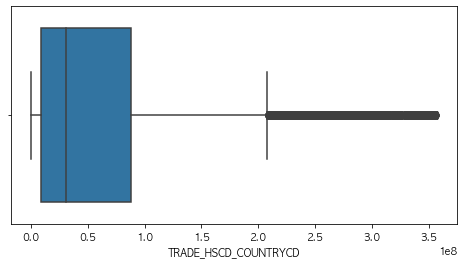

In [69]:
#TRADE_HSCD_COUNTRYCD에 대한 이상치의 존재 확인

plt.figure(figsize=(8,4))
sns.boxplot(train['TRADE_HSCD_COUNTRYCD'])

# 3. 기존 변수 데이터 전처리

### NY_GDP_MKTP_CD - GDP  변수
- - `연간 GDP 변화율` :(NY_GDP_MKTP_CD - NY_GDP_MKTP_CD_1Y)/NY_GDP_MKTP_CD_1Y
- - `1인당 GDP` : NY_GDP_MKTP_CD - GDP  / SP_POP_TOTL

In [88]:
#학습 데이터 복사본 생성
traindata = train.copy()

In [89]:
df_gdp = traindata[['COUNTRYNM','HSCD','NY_GDP_MKTP_CD','NY_GDP_MKTP_CD_1Y','SP_POP_TOTL']]

In [90]:
df_gdp['gdp_diff']=(df_gdp['NY_GDP_MKTP_CD']-df_gdp['NY_GDP_MKTP_CD_1Y']) /df_gdp['NY_GDP_MKTP_CD_1Y']

In [91]:
df_gdp['1_gdp']=df_gdp['NY_GDP_MKTP_CD']/df_gdp['SP_POP_TOTL']

In [92]:
df_gdp=df_gdp[['HSCD','COUNTRYNM','gdp_diff','1_gdp']]

In [93]:
#기존의 데이터프레임에 새로운 변수를 병합
train1 = pd.merge(train, df_gdp, how='left',on=['COUNTRYNM','HSCD'])

In [94]:
train1.isna().sum()

UNC_YEAR                    0
HSCD                        0
COUNTRYCD                   0
COUNTRYNM                   0
TRADE_COUNTRYCD             0
TRADE_HSCD                  0
TARIFF_AVG                 60
SNDIST                      1
NY_GDP_MKTP_CD              0
NY_GDP_MKTP_CD_1Y           0
SP_POP_TOTL                 0
PA_NUS_FCRF                 0
IC_BUS_EASE_DFRN_DB         0
KMDIST                      0
TRADE_HSCD_COUNTRYCD        0
KR_TRADE_HSCD_COUNTRYCD     0
gdp_diff                    0
1_gdp                       0
dtype: int64

In [95]:
#평균 값으로 대치하기
train1 = train1.where(pd.notnull(train1), train1.mean(), axis='columns')

### TRADE_COUNTRYCD-변수 이용
- 품목별 무역 의존도: 해당 연도 해당 구각의 해당 품목 수입금액/ 해당 연도 해당 국가의 전체 품목 수입금액

In [97]:
#학습 데이터 복사본 생성
traindata = train.copy()

In [98]:
df_tc = traindata[['COUNTRYNM','HSCD','TRADE_COUNTRYCD','TRADE_HSCD_COUNTRYCD']]

In [99]:
df_tc['item_depend']=df_tc['TRADE_COUNTRYCD'] /df_tc['TRADE_HSCD_COUNTRYCD']

In [100]:
df_tc= df_tc[['HSCD','COUNTRYNM','item_depend']]

In [101]:
#기존의 데이터프레임에 새로운 변수를 병합
train2 = pd.merge(train1, df_tc, how='left',on=['COUNTRYNM','HSCD'])

In [102]:
#평균 값으로 대치하기
train2 = train2.where(pd.notnull(train2), train2.mean(), axis='columns')

### TRADE_HSCD 해당 연도 해당 품목 전세계 총 수입금액
- 나라별 무역 의존도: 해당 연도 해당 국가의 해당 품목 수입금액/ 해당 연도 해당 품목의전세계 총 수입금액

In [108]:
#학습 데이터 복사본 생성
traindata = train.copy()

In [109]:
df_th = traindata[['COUNTRYNM','HSCD','TRADE_HSCD_COUNTRYCD','TRADE_HSCD']]

In [110]:
df_th['country_depend']=df_th['TRADE_HSCD_COUNTRYCD'] /df_th['TRADE_HSCD']

In [111]:
df_th = df_th[['COUNTRYNM','HSCD','country_depend']]

In [112]:
#기존의 데이터프레임에 새로운 변수를 병합
train3 = pd.merge(train2, df_th, how='left',on=['COUNTRYNM','HSCD'])

In [113]:
#평균 값으로 대치하기
train3 = train3.where(pd.notnull(train3), train3.mean(), axis='columns')

### TARIFF_AVG
- 해당 국가에서 해당 품목에 적용되는 평균 관세율은 그대로 

### SNDIST
- 해당 국가와 수입 국가 간 평균 거리 
- 파생변수
- 품목별 평균 거리 = 품목별로 SNDIST의 평균을 구한다. 
- 품목별 평균 거리당 수익 =TRADE_HSCD_COUNTRYCD/SNDIST

In [115]:
#전체품목 데이터를 위해 다시 불러오기 
train_sp = pd.read_csv('공모전데이터_분석용_KOTRA_0525.csv')

In [116]:
df_sn = train_sp[['HSCD','COUNTRYNM','SNDIST','TRADE_HSCD_COUNTRYCD']]

In [117]:
#품목별 평균 거리당 수익 TRADE_HSCD_COUNTRYCD/SNDIST
df_sn['item_md_rv'] = df_sn['TRADE_HSCD_COUNTRYCD']/df_sn['SNDIST']

In [118]:
#문자형으로 바꾸기 
df_sn['HSCD'] = df_sn['HSCD'].astype(str)

In [119]:
#품목별 SNDIST평균 구하는 코드
def sndist_mean():
    #전체 데이터에서 train 데이터에 해당하는 행 추출
    #train_data = train.reset_index(drop=True)
    
    #일괄적으로 1의 값을 가지는 in_out_mean 변수 생성
    df_sn['sndist_mean']=1
    
    #품목ㅂ 인덱스 추출
    index_190590 = df_sn.query('HSCD=="190590"').index #190590
    index_852852 = df_sn.query('HSCD=="852852"').index #852852
    
    index_190590 = df_sn.query('HSCD=="190590"').index
    index_190230 = df_sn.query('HSCD=="190230"').index
    index_190219 = df_sn.query('HSCD=="190219"').index
    index_591190 = df_sn.query('HSCD=="591190"').index
    index_590390 = df_sn.query('HSCD=="590390"').index
    index_550320 = df_sn.query('HSCD=="550320"').index
    index_540769 = df_sn.query('HSCD=="540769"').index
    index_540761 = df_sn.query('HSCD=="540761"').index
    index_540752 = df_sn.query('HSCD=="540752"').index
    index_292910 = df_sn.query('HSCD=="292910"').index
    index_271019 = df_sn.query('HSCD=="271019"').index
    index_210690 = df_sn.query('HSCD=="210690"').index
    index_210390 = df_sn.query('HSCD=="210390"').index
    index_491199 = df_sn.query('HSCD=="491199"').index
    index_491110 = df_sn.query('HSCD=="491110"').index
    index_491000 = df_sn.query('HSCD=="491000"').index
    index_490199 = df_sn.query('HSCD=="490199"').index
    index_490110 = df_sn.query('HSCD=="490110"').index
    index_482390 = df_sn.query('HSCD=="482390"').index
    index_482190 = df_sn.query('HSCD=="482190"').index
    index_482110 = df_sn.query('HSCD=="482110"').index
    index_482010 = df_sn.query('HSCD=="482010"').index
    index_481940 = df_sn.query('HSCD=="481940"').index
    index_481920 = df_sn.query('HSCD=="481920"').index
    index_481910 = df_sn.query('HSCD=="481910"').index
    index_481890 = df_sn.query('HSCD=="481890"').index
    index_481820 = df_sn.query('HSCD=="481820"').index
    index_481141 = df_sn.query('HSCD=="481141"').index
    index_420299 = df_sn.query('HSCD=="420299"').index
    index_420292 = df_sn.query('HSCD=="420292"').index
    index_420232 = df_sn.query('HSCD=="420232"').index
    index_420212 = df_sn.query('HSCD=="420212"').index
    index_401699 = df_sn.query('HSCD=="401699"').index
    index_401693 = df_sn.query('HSCD=="401693"').index
    index_401691 = df_sn.query('HSCD=="401691"').index
    index_401610 = df_sn.query('HSCD=="401610"').index
    index_401390 = df_sn.query('HSCD=="401390"').index
    index_401310 = df_sn.query('HSCD=="401310"').index
    index_401290 = df_sn.query('HSCD=="401290"').index
    index_401120 = df_sn.query('HSCD=="401120"').index
    index_401110 = df_sn.query('HSCD=="401110"').index
    index_401039 = df_sn.query('HSCD=="401039"').index
    index_401035 = df_sn.query('HSCD=="401035"').index
    index_401032 = df_sn.query('HSCD=="401032"').index
    index_401031 = df_sn.query('HSCD=="401031"').index
    index_401019 = df_sn.query('HSCD=="401019"').index
    index_400942 = df_sn.query('HSCD=="400942"').index
    index_400941 = df_sn.query('HSCD=="400941"').index
    index_400932 = df_sn.query('HSCD=="400932"').index
    index_400931 = df_sn.query('HSCD=="400931"').index
    index_400922 = df_sn.query('HSCD=="400922"').index
    index_400912 = df_sn.query('HSCD=="400912"').index
    index_400911 = df_sn.query('HSCD=="400911"').index
    index_392690 = df_sn.query('HSCD=="392690"').index
    index_392630 = df_sn.query('HSCD=="392630"').index
    index_392620 = df_sn.query('HSCD=="392620"').index
    index_392610 = df_sn.query('HSCD=="392610"').index
    index_392590 = df_sn.query('HSCD=="392590"').index
    index_392490 = df_sn.query('HSCD=="392490"').index
    index_392410 = df_sn.query('HSCD=="392410"').index
    index_392390 = df_sn.query('HSCD=="392390"').index
    index_392350 = df_sn.query('HSCD=="392350"').index
    index_392330 = df_sn.query('HSCD=="392330"').index
    index_392329 = df_sn.query('HSCD=="392329"').index
    index_392321 = df_sn.query('HSCD=="392321"').index
    index_392310 = df_sn.query('HSCD=="392310"').index
    index_392190 = df_sn.query('HSCD=="392190"').index
    index_392119 = df_sn.query('HSCD=="392119"').index
    index_392099 = df_sn.query('HSCD=="392099"').index
    index_392049 = df_sn.query('HSCD=="392049"').index
    index_392020 = df_sn.query('HSCD=="392020"').index
    index_392010 = df_sn.query('HSCD=="392010"').index
    index_391990 = df_sn.query('HSCD=="391990"').index
    index_391910 = df_sn.query('HSCD=="391910"').index
    index_391810 = df_sn.query('HSCD=="391810"').index
    index_391740 = df_sn.query('HSCD=="391740"').index
    index_391739 = df_sn.query('HSCD=="391739"').index
    index_391732 = df_sn.query('HSCD=="391732"').index
    index_391729 = df_sn.query('HSCD=="391729"').index
    index_391239 = df_sn.query('HSCD=="391239"').index
    index_391000 = df_sn.query('HSCD=="391000"').index
    index_390730 = df_sn.query('HSCD=="390730"').index
    index_390720 = df_sn.query('HSCD=="390720"').index
    index_390690 = df_sn.query('HSCD=="390690"').index
    index_390230 = df_sn.query('HSCD=="390230"').index
    index_390210 = df_sn.query('HSCD=="390210"').index
    index_390120 = df_sn.query('HSCD=="390120"').index
    index_390110 = df_sn.query('HSCD=="390110"').index
    index_382200 = df_sn.query('HSCD=="382200"').index
    index_381400 = df_sn.query('HSCD=="381400"').index
    index_350699 = df_sn.query('HSCD=="350699"').index
    index_350691 = df_sn.query('HSCD=="350691"').index
    index_350610 = df_sn.query('HSCD=="350610"').index
    index_340700 = df_sn.query('HSCD=="340700"').index
    index_340319 = df_sn.query('HSCD=="340319"').index
    index_340290 = df_sn.query('HSCD=="340290"').index
    index_340220 = df_sn.query('HSCD=="340220"').index
    index_330790 = df_sn.query('HSCD=="330790"').index
    index_330590 = df_sn.query('HSCD=="330590"').index
    index_330510 = df_sn.query('HSCD=="330510"').index
    index_330499 = df_sn.query('HSCD=="330499"').index
    index_330491 = df_sn.query('HSCD=="330491"').index
    index_330430 = df_sn.query('HSCD=="330430"').index
    index_330420 = df_sn.query('HSCD=="330420"').index
    index_330410 = df_sn.query('HSCD=="330410"').index
    index_321590 = df_sn.query('HSCD=="321590"').index
    
    index_321519 = df_sn.query('HSCD=="321519"').index
    index_321511 = df_sn.query('HSCD=="321511"').index
    index_320890 = df_sn.query('HSCD=="320890"').index
    index_300640 = df_sn.query('HSCD=="300640"').index
    index_300610 = df_sn.query('HSCD=="300610"').index
    index_300590 = df_sn.query('HSCD=="300590"').index
    
    index_300510 = df_sn.query('HSCD=="300510"').index
    index_300490 = df_sn.query('HSCD=="300490"').index
    index_761699 = df_sn.query('HSCD=="761699"').index
    index_761510 = df_sn.query('HSCD=="761510"').index
    index_741999 = df_sn.query('HSCD=="741999"').index
    index_741220 = df_sn.query('HSCD=="741220"').index
    index_732690 = df_sn.query('HSCD=="732690"').index
    index_732399 = df_sn.query('HSCD=="732399"').index
    
    index_732393 = df_sn.query('HSCD=="732393"').index
    index_732111 = df_sn.query('HSCD=="732111"').index
    index_732090 = df_sn.query('HSCD=="732090"').index
    index_732020 = df_sn.query('HSCD=="732020"').index
    index_731829 = df_sn.query('HSCD=="731829"').index
    index_731824 = df_sn.query('HSCD=="731824"').index
    index_731822 = df_sn.query('HSCD=="731822"').index
    index_731821 = df_sn.query('HSCD=="731821"').index
    
    
    index_731819 = df_sn.query('HSCD=="731819"').index
    index_731816 = df_sn.query('HSCD=="731816"').index
    index_731815 = df_sn.query('HSCD=="731815"').index
    index_731589 = df_sn.query('HSCD=="731589"').index
    index_731512 = df_sn.query('HSCD=="731512"').index
    index_731511 = df_sn.query('HSCD=="731511"').index
    index_731290 = df_sn.query('HSCD=="731290"').index
    index_731210 = df_sn.query('HSCD=="731210"').index
    
    index_730890 = df_sn.query('HSCD=="730890"').index
    index_730799 = df_sn.query('HSCD=="730799"').index
    index_730792 = df_sn.query('HSCD=="730792"').index
    index_730791 = df_sn.query('HSCD=="730791"').index
    index_730729 = df_sn.query('HSCD=="730729"').index
    index_730722 = df_sn.query('HSCD=="730722"').index
    index_730721 = df_sn.query('HSCD=="730721"').index
    index_730719 = df_sn.query('HSCD=="730719"').index
    
    index_730890 = df_sn.query('HSCD=="730890"').index
    index_730799 = df_sn.query('HSCD=="730799"').index
    index_730792 = df_sn.query('HSCD=="730792"').index
    index_730791 = df_sn.query('HSCD=="730791"').index
    index_730729 = df_sn.query('HSCD=="730729"').index
    index_730722 = df_sn.query('HSCD=="730722"').index
    index_730721 = df_sn.query('HSCD=="730721"').index
    index_730719 = df_sn.query('HSCD=="730719"').index
    
    index_721070 = df_sn.query('HSCD=="721070"').index
    index_711790 = df_sn.query('HSCD=="711790"').index
    index_711719 = df_sn.query('HSCD=="711719"').index
    index_700992 = df_sn.query('HSCD=="700992"').index
    index_700910 = df_sn.query('HSCD=="700910"').index
    index_700721 = df_sn.query('HSCD=="700721"').index
    index_700711 = df_sn.query('HSCD=="700711"').index
    index_999999 = df_sn.query('HSCD=="999999"').index
    
    index_961620 = df_sn.query('HSCD=="961620"').index
    index_961590 = df_sn.query('HSCD=="961590"').index
    index_961210 = df_sn.query('HSCD=="961210"').index
    index_960990 = df_sn.query('HSCD=="960990"').index
    index_960910 = df_sn.query('HSCD=="960910"').index
    index_960820 = df_sn.query('HSCD=="960820"').index
    index_960810 = df_sn.query('HSCD=="960810"').index
    index_960390 = df_sn.query('HSCD=="960390"').index
    
    index_960330 = df_sn.query('HSCD=="960330"').index
    index_960329 = df_sn.query('HSCD=="960329"').index
    index_950790 = df_sn.query('HSCD=="950790"').index
    index_950720 = df_sn.query('HSCD=="950720"').index
    index_950699 = df_sn.query('HSCD=="950699"').index
    index_950691 = df_sn.query('HSCD=="950691"').index
    index_950300 = df_sn.query('HSCD=="950300"').index
    index_940599 = df_sn.query('HSCD=="940599"').index
    
    index_940560 = df_sn.query('HSCD=="940560"').index
    index_940540 = df_sn.query('HSCD=="940540"').index
    index_940510 = df_sn.query('HSCD=="940510"').index
    index_940490 = df_sn.query('HSCD=="940490"').index
    index_940390 = df_sn.query('HSCD=="940390"').index
    index_940370 = df_sn.query('HSCD=="940370"').index
    index_940360 = df_sn.query('HSCD=="940360"').index
    index_940320 = df_sn.query('HSCD=="940320"').index
    
    index_940290 = df_sn.query('HSCD=="940290"').index
    index_940190 = df_sn.query('HSCD=="940190"').index
    index_940180 = df_sn.query('HSCD=="940180"').index
    index_940130 = df_sn.query('HSCD=="940130"').index
    index_940120 = df_sn.query('HSCD=="940120"').index
    index_903300 = df_sn.query('HSCD=="903300"').index
    index_903290 = df_sn.query('HSCD=="903290"').index
    index_903289 = df_sn.query('HSCD=="903289"').index
    
    index_903210 = df_sn.query('HSCD=="903210"').index
    index_903190 = df_sn.query('HSCD=="903190"').index
    index_903180 = df_sn.query('HSCD=="903180"').index
    index_903149 = df_sn.query('HSCD=="903149"').index
    index_903033 = df_sn.query('HSCD=="903033"').index
    index_902990 = df_sn.query('HSCD=="902990"').index
    index_902920 = df_sn.query('HSCD=="902920"').index
    index_902910 = df_sn.query('HSCD=="902910"').index
   
    
    index_902790 = df_sn.query('HSCD=="902790"').index
    index_902780 = df_sn.query('HSCD=="902780"').index
    index_902710 = df_sn.query('HSCD=="902710"').index
    index_902690 = df_sn.query('HSCD=="902690"').index
    index_902680 = df_sn.query('HSCD=="902680"').index
    index_902620 = df_sn.query('HSCD=="902620"').index
    index_902610 = df_sn.query('HSCD=="902610"').index
    index_902590 = df_sn.query('HSCD=="902590"').index
   
    index_902580 = df_sn.query('HSCD=="902580"').index
    index_902519 = df_sn.query('HSCD=="902519"').index
    index_902300 = df_sn.query('HSCD=="902300"').index
    index_902290 = df_sn.query('HSCD=="902290"').index
    index_902214 = df_sn.query('HSCD=="902214"').index
    index_902213 = df_sn.query('HSCD=="902213"').index
    index_902190 = df_sn.query('HSCD=="902190"').index
    index_902129 = df_sn.query('HSCD=="902129"').index
   
    index_902110 = df_sn.query('HSCD=="902110"').index
    index_901910 = df_sn.query('HSCD=="901910"').index
    index_901890 = df_sn.query('HSCD=="901890"').index
    index_901850 = df_sn.query('HSCD=="901850"').index
    index_901849 = df_sn.query('HSCD=="901849"').index
    index_901839 = df_sn.query('HSCD=="901839"').index
    index_901832 = df_sn.query('HSCD=="901832"').index
    index_901819 = df_sn.query('HSCD=="901819"').index
    
    index_901812 = df_sn.query('HSCD=="901812"').index
    index_901780 = df_sn.query('HSCD=="901780"').index
    index_900490 = df_sn.query('HSCD=="900490"').index
    index_900410 = df_sn.query('HSCD=="900410"').index
    index_900319 = df_sn.query('HSCD=="900319"').index
    index_900211 = df_sn.query('HSCD=="900211"').index
    index_900150 = df_sn.query('HSCD=="900150"').index
    index_900130 = df_sn.query('HSCD=="900130"').index

    index_691110 = df_sn.query('HSCD=="691110"').index
    index_680530 = df_sn.query('HSCD=="680530"').index
    index_680520 = df_sn.query('HSCD=="680520"').index
    index_680422 = df_sn.query('HSCD=="680422"').index
    index_680421 = df_sn.query('HSCD=="680421"').index
    index_670419 = df_sn.query('HSCD=="670419"').index
    index_650610 = df_sn.query('HSCD=="650610"').index
    index_650500 = df_sn.query('HSCD=="650500"').index


    index_640419 = df_sn.query('HSCD=="640419"').index
    index_630790 = df_sn.query('HSCD=="630790"').index
    index_630710 = df_sn.query('HSCD=="630710"').index
    index_621710 = df_sn.query('HSCD=="621710"').index
    index_621600 = df_sn.query('HSCD=="621600"').index
    index_611610 = df_sn.query('HSCD=="611610"').index
    index_611595 = df_sn.query('HSCD=="611595"').index
    index_610990 = df_sn.query('HSCD=="610990"').index
    
    index_610910 = df_sn.query('HSCD=="610910"').index
    index_600632 = df_sn.query('HSCD=="600632"').index
    index_600410 = df_sn.query('HSCD=="600410"').index
    index_870899 = df_sn.query('HSCD=="870899"').index
    index_870895 = df_sn.query('HSCD=="870895"').index
    index_870894 = df_sn.query('HSCD=="870894"').index
    index_870893 = df_sn.query('HSCD=="870893"').index
    index_870892 = df_sn.query('HSCD=="870892"').index
    
    index_870810 = df_sn.query('HSCD=="870810"').index
    index_870421 = df_sn.query('HSCD=="870421"').index
    index_870332 = df_sn.query('HSCD=="870332"').index
    index_870324 = df_sn.query('HSCD=="870324"').index
    index_870323 = df_sn.query('HSCD=="870323"').index
    index_870322 = df_sn.query('HSCD=="870322"').index
    index_870321 = df_sn.query('HSCD=="870321"').index
    index_854470 = df_sn.query('HSCD=="854470"').index
    
    
    index_854449 = df_sn.query('HSCD=="854449"').index
    index_854442 = df_sn.query('HSCD=="854442"').index
    index_854430 = df_sn.query('HSCD=="854430"').index
    index_854420 = df_sn.query('HSCD=="854420"').index
    index_854390 = df_sn.query('HSCD=="854390"').index
    index_854370 = df_sn.query('HSCD=="854370"').index
    index_854239 = df_sn.query('HSCD=="854239"').index
    index_854232 = df_sn.query('HSCD=="854232"').index
    
    index_854231 = df_sn.query('HSCD=="854231"').index
    index_854140 = df_sn.query('HSCD=="854140"').index
    index_854129 = df_sn.query('HSCD=="854129"').index
    index_854110 = df_sn.query('HSCD=="854110"').index
    index_853949 = df_sn.query('HSCD=="853949"').index
    index_853929 = df_sn.query('HSCD=="853929"').index
    index_853922 = df_sn.query('HSCD=="853922"').index
    index_853921 = df_sn.query('HSCD=="853921"').index
    
    index_853890 = df_sn.query('HSCD=="853890"').index
    index_853810 = df_sn.query('HSCD=="853810"').index
    index_853710 = df_sn.query('HSCD=="853710"').index
    index_853690 = df_sn.query('HSCD=="853690"').index
    index_853670 = df_sn.query('HSCD=="853670"').index
    index_853669 = df_sn.query('HSCD=="853669"').index
    index_853650 = df_sn.query('HSCD=="853650"').index
    index_853649 = df_sn.query('HSCD=="853649"').index
    
    index_853641 = df_sn.query('HSCD=="853641"').index
    index_853630 = df_sn.query('HSCD=="853630"').index
    index_853620 = df_sn.query('HSCD=="853620"').index
    index_853610 = df_sn.query('HSCD=="853610"').index
    index_853590 = df_sn.query('HSCD=="853590"').index
    index_853400 = df_sn.query('HSCD=="853400"').index
    index_853340 = df_sn.query('HSCD=="853340"').index
    index_853329 = df_sn.query('HSCD=="853329"').index
    
    index_853229 = df_sn.query('HSCD=="853229"').index
    index_853190 = df_sn.query('HSCD=="853190"').index
    index_853180 = df_sn.query('HSCD=="853180"').index
    index_853120 = df_sn.query('HSCD=="853120"').index
    index_853110 = df_sn.query('HSCD=="853110"').index
    index_852990 = df_sn.query('HSCD=="852990"').index
    index_852910 = df_sn.query('HSCD=="852910"').index
    index_852872 = df_sn.query('HSCD=="852872"').index
    
    index_852871 = df_sn.query('HSCD=="852871"').index
    index_852869 = df_sn.query('HSCD=="852869"').index
    index_852859 = df_sn.query('HSCD=="852859"').index
    index_852721 = df_sn.query('HSCD=="852721"').index
    index_852692 = df_sn.query('HSCD=="852692"').index
    index_852691 = df_sn.query('HSCD=="852691"').index
    index_852580 = df_sn.query('HSCD=="852580"').index
    index_852352 = df_sn.query('HSCD=="852352"').index
    
    index_852351 = df_sn.query('HSCD=="852351"').index
    index_852349 = df_sn.query('HSCD=="852349"').index
    index_852290 = df_sn.query('HSCD=="852290"').index
    index_852190 = df_sn.query('HSCD=="852190"').index
    index_851890 = df_sn.query('HSCD=="851890"').index
    index_851840 = df_sn.query('HSCD=="851840"').index
    index_851830 = df_sn.query('HSCD=="851830"').index
    index_851829 = df_sn.query('HSCD=="851829"').index
    
    index_851821 = df_sn.query('HSCD=="851821"').index
    index_851810 = df_sn.query('HSCD=="851810"').index
    index_851770 = df_sn.query('HSCD=="851770"').index
    index_851769 = df_sn.query('HSCD=="851769"').index
    index_851762 = df_sn.query('HSCD=="851762"').index
    index_851718 = df_sn.query('HSCD=="851718"').index
    index_851712 = df_sn.query('HSCD=="851712"').index
    index_851690 = df_sn.query('HSCD=="851690"').index
    
    index_851680 = df_sn.query('HSCD=="851680"').index
    index_851679 = df_sn.query('HSCD=="851679"').index
    index_851660 = df_sn.query('HSCD=="851660"').index
    index_851650 = df_sn.query('HSCD=="851650"').index
    index_851629 = df_sn.query('HSCD=="851629"').index
    index_851610 = df_sn.query('HSCD=="851610"').index
    index_851590 = df_sn.query('HSCD=="851590"').index
    index_851580 = df_sn.query('HSCD=="851580"').index
    
    index_851310 = df_sn.query('HSCD=="851310"').index
    index_851290 = df_sn.query('HSCD=="851290"').index
    index_851240 = df_sn.query('HSCD=="851240"').index
    index_851230 = df_sn.query('HSCD=="851230"').index
    index_851220 = df_sn.query('HSCD=="851220"').index
    index_851190 = df_sn.query('HSCD=="851190"').index
    index_851180 = df_sn.query('HSCD=="851180"').index
    index_851150 = df_sn.query('HSCD=="851150"').index
    
    index_851140 = df_sn.query('HSCD=="851140"').index
    index_851130 = df_sn.query('HSCD=="851130"').index
    index_851110 = df_sn.query('HSCD=="851110"').index
    index_850980 = df_sn.query('HSCD=="850980"').index
    index_850940 = df_sn.query('HSCD=="850940"').index
    index_850780 = df_sn.query('HSCD=="850780"').index
    index_850760 = df_sn.query('HSCD=="850760"').index
    index_850720 = df_sn.query('HSCD=="850720"').index
    
    index_850710 = df_sn.query('HSCD=="850710"').index
    index_850680 = df_sn.query('HSCD=="850680"').index
    index_850650 = df_sn.query('HSCD=="850650"').index
    index_850590 = df_sn.query('HSCD=="850590"').index
    index_850490 = df_sn.query('HSCD=="850490"').index
    index_850450 = df_sn.query('HSCD=="850450"').index
    index_850440 = df_sn.query('HSCD=="850440"').index
    index_850431 = df_sn.query('HSCD=="850431"').index
    
    index_850300 = df_sn.query('HSCD=="850300"').index
    index_850140 = df_sn.query('HSCD=="850140"').index
    index_850131 = df_sn.query('HSCD=="850131"').index
    index_850120 = df_sn.query('HSCD=="850120"').index
    index_850110 = df_sn.query('HSCD=="850110"').index
    index_848790 = df_sn.query('HSCD=="848790"').index
    index_848490 = df_sn.query('HSCD=="848490"').index
    index_848420 = df_sn.query('HSCD=="848420"').index
    
    index_848410 = df_sn.query('HSCD=="848410"').index
    index_848390 = df_sn.query('HSCD=="848390"').index
    index_848360 = df_sn.query('HSCD=="848360"').index
    index_848350 = df_sn.query('HSCD=="848350"').index
    index_848340 = df_sn.query('HSCD=="848340"').index
    index_848330 = df_sn.query('HSCD=="848330"').index
    index_848320 = df_sn.query('HSCD=="848320"').index
    index_848310 = df_sn.query('HSCD=="848310"').index
    
    index_848299 = df_sn.query('HSCD=="848299"').index
    index_848280 = df_sn.query('HSCD=="848280"').index
    index_848250 = df_sn.query('HSCD=="848250"').index
    index_848240 = df_sn.query('HSCD=="848240"').index
    index_848220 = df_sn.query('HSCD=="848220"').index
    index_848210 = df_sn.query('HSCD=="848210"').index
    index_848190 = df_sn.query('HSCD=="848190"').index
    index_848180 = df_sn.query('HSCD=="848180"').index
    
    index_848140 = df_sn.query('HSCD=="848140"').index
    index_848130 = df_sn.query('HSCD=="848130"').index
    index_848120 = df_sn.query('HSCD=="848120"').index
    index_848110 = df_sn.query('HSCD=="848110"').index
    index_847990 = df_sn.query('HSCD=="847990"').index
    index_847989 = df_sn.query('HSCD=="847989"').index
    index_847982 = df_sn.query('HSCD=="847982"').index
    index_847790 = df_sn.query('HSCD=="847790"').index
    
    index_847340 = df_sn.query('HSCD=="847340"').index
    index_847330 = df_sn.query('HSCD=="847330"').index
    index_847290 = df_sn.query('HSCD=="847290"').index
    index_847190 = df_sn.query('HSCD=="847190"').index
    index_847180 = df_sn.query('HSCD=="847180"').index
    index_847170 = df_sn.query('HSCD=="847170"').index
    index_847160 = df_sn.query('HSCD=="847160"').index
    index_847150 = df_sn.query('HSCD=="847150"').index
    
    index_847149 = df_sn.query('HSCD=="847149"').index
    index_847141 = df_sn.query('HSCD=="847141"').index
    index_847130 = df_sn.query('HSCD=="847130"').index
    index_846799 = df_sn.query('HSCD=="846799"').index
    index_846729 = df_sn.query('HSCD=="846729"').index
    index_846721 = df_sn.query('HSCD=="846721"').index
    index_846693 = df_sn.query('HSCD=="846693"').index
    index_845090 = df_sn.query('HSCD=="845090"').index
    
    index_845020 = df_sn.query('HSCD=="845020"').index
    index_845011 = df_sn.query('HSCD=="845011"').index
    index_844399 = df_sn.query('HSCD=="844399"').index
    index_844339 = df_sn.query('HSCD=="844339"').index
    index_844332 = df_sn.query('HSCD=="844332"').index
    index_844331 = df_sn.query('HSCD=="844331"').index
    index_843149 = df_sn.query('HSCD=="843149"').index
    index_843143 = df_sn.query('HSCD=="843143"').index
    
    index_843141 = df_sn.query('HSCD=="843141"').index
    index_843139 = df_sn.query('HSCD=="843139"').index
    index_843131 = df_sn.query('HSCD=="843131"').index
    index_843120 = df_sn.query('HSCD=="843120"').index
    index_842952 = df_sn.query('HSCD=="842952"').index
    index_842890 = df_sn.query('HSCD=="842890"').index
    index_842720 = df_sn.query('HSCD=="842720"').index
    index_842549 = df_sn.query('HSCD=="842549"').index
    
    index_842490 = df_sn.query('HSCD=="842490"').index
    index_842489 = df_sn.query('HSCD=="842489"').index
    index_842420 = df_sn.query('HSCD=="842420"').index
    index_842381 = df_sn.query('HSCD=="842381"').index
    index_842290 = df_sn.query('HSCD=="842290"').index
    index_842240 = df_sn.query('HSCD=="842240"').index
    index_842199 = df_sn.query('HSCD=="842199"').index
    index_842139 = df_sn.query('HSCD=="842139"').index
    
    index_842131 = df_sn.query('HSCD=="842131"').index
    index_842129 = df_sn.query('HSCD=="842129"').index
    index_842123 = df_sn.query('HSCD=="842123"').index
    index_842121 = df_sn.query('HSCD=="842121"').index
    index_842119 = df_sn.query('HSCD=="842119"').index
    index_841990 = df_sn.query('HSCD=="841990"').index
    index_841989 = df_sn.query('HSCD=="841989"').index
    index_841950 = df_sn.query('HSCD=="841950"').index
    
    index_841899 = df_sn.query('HSCD=="841899"').index
    index_841869 = df_sn.query('HSCD=="841869"').index
    index_841821 = df_sn.query('HSCD=="841821"').index
    index_841810 = df_sn.query('HSCD=="841810"').index
    index_841590 = df_sn.query('HSCD=="841590"').index
    index_841582 = df_sn.query('HSCD=="841582"').index
    index_841510 = df_sn.query('HSCD=="841510"').index
    index_841490 = df_sn.query('HSCD=="841490"').index
    
    index_841480 = df_sn.query('HSCD=="841480"').index
    index_841459 = df_sn.query('HSCD=="841459"').index
    index_841451 = df_sn.query('HSCD=="841451"').index
    index_841430 = df_sn.query('HSCD=="841430"').index
    index_841410 = df_sn.query('HSCD=="841410"').index
    index_841391 = df_sn.query('HSCD=="841391"').index
    index_841381 = df_sn.query('HSCD=="841381"').index
    index_841370 = df_sn.query('HSCD=="841370"').index
    
    index_841360 = df_sn.query('HSCD=="841360"').index
    index_841350 = df_sn.query('HSCD=="841350"').index
    index_841330 = df_sn.query('HSCD=="841330"').index
    index_841320 = df_sn.query('HSCD=="841320"').index
    index_841319 = df_sn.query('HSCD=="841319"').index
    index_841290 = df_sn.query('HSCD=="841290"').index
    index_841229 = df_sn.query('HSCD=="841229"').index
    index_841221 = df_sn.query('HSCD=="841221"').index
    
    index_840999 = df_sn.query('HSCD=="840999"').index
    index_840991 = df_sn.query('HSCD=="840991"').index
    index_840890 = df_sn.query('HSCD=="840890"').index
    index_840820 = df_sn.query('HSCD=="840820"').index
    index_840734 = df_sn.query('HSCD=="840734"').index
    index_831120 = df_sn.query('HSCD=="831120"').index
    index_831110 = df_sn.query('HSCD=="831110"').index
    index_831000 = df_sn.query('HSCD=="831000"').index
    
    index_830710 = df_sn.query('HSCD=="830710"').index
    index_830300 = df_sn.query('HSCD=="830300"').index
    index_830260 = df_sn.query('HSCD=="830260"').index
    index_830250 = df_sn.query('HSCD=="830250"').index
    index_830249 = df_sn.query('HSCD=="830249"').index
    index_830241 = df_sn.query('HSCD=="830241"').index
    index_830230 = df_sn.query('HSCD=="830230"').index
    index_830210 = df_sn.query('HSCD=="830210"').index
    
    index_830170 = df_sn.query('HSCD=="830170"').index
    index_830160 = df_sn.query('HSCD=="830160"').index
    index_830140 = df_sn.query('HSCD=="830140"').index
    index_830120 = df_sn.query('HSCD=="830120"').index
    index_821599 = df_sn.query('HSCD=="821599"').index
    index_821420 = df_sn.query('HSCD=="821420"').index
    index_821300 = df_sn.query('HSCD=="821300"').index
    index_820890 = df_sn.query('HSCD=="820890"').index
    
    index_820790 = df_sn.query('HSCD=="820790"').index
    index_820750 = df_sn.query('HSCD=="820750"').index
    index_820719 = df_sn.query('HSCD=="820719"').index
    index_820600 = df_sn.query('HSCD=="820600"').index
    index_820559 = df_sn.query('HSCD=="820559"').index
    index_820411 = df_sn.query('HSCD=="820411"').index
    index_820320 = df_sn.query('HSCD=="820320"').index
    index_820299 = df_sn.query('HSCD=="820299"').index
    
    index_820239 = df_sn.query('HSCD=="820239"').index
    index_820239 = df_sn.query('HSCD=="820239"').index
    index_382499 = df_sn.query('HSCD=="382499"').index
    index_852852 = df_sn.query('HSCD=="852852"').index
    
    
    df_sn.iloc[index_852852,-1] = df_sn.query('HSCD=="852852"').index
    
    
    #인덱스를 활용하여 TRADE_HSCD_mean의 값을 나라 별에 맞는 평균 TRADE_HSCD로 변경
    df_sn.iloc[index_190590,-1] = df_sn.query('HSCD=="190590"')['SNDIST'].mean()
    df_sn.iloc[index_190230,-1] = df_sn.query('HSCD=="190230"')['SNDIST'].mean()
    df_sn.iloc[index_190219,-1] = df_sn.query('HSCD=="190219"')['SNDIST'].mean()
    df_sn.iloc[index_591190,-1] = df_sn.query('HSCD=="591190"')['SNDIST'].mean()
    df_sn.iloc[index_590390,-1] = df_sn.query('HSCD=="590390"')['SNDIST'].mean()
    df_sn.iloc[index_550320,-1] = df_sn.query('HSCD=="550320"')['SNDIST'].mean()
    df_sn.iloc[index_540769,-1] = df_sn.query('HSCD=="540769"')['SNDIST'].mean()
    df_sn.iloc[index_540761,-1] = df_sn.query('HSCD=="540761"')['SNDIST'].mean()
    df_sn.iloc[index_540752,-1] = df_sn.query('HSCD=="540752"')['SNDIST'].mean()
    df_sn.iloc[index_292910,-1] = df_sn.query('HSCD=="292910"')['SNDIST'].mean()
    df_sn.iloc[index_271019,-1] = df_sn.query('HSCD=="271019"')['SNDIST'].mean()
    df_sn.iloc[index_210690,-1] = df_sn.query('HSCD=="210690"')['SNDIST'].mean()
    df_sn.iloc[index_210390,-1] = df_sn.query('HSCD=="210390"')['SNDIST'].mean()
    df_sn.iloc[index_491199,-1] = df_sn.query('HSCD=="491199"')['SNDIST'].mean()
    df_sn.iloc[index_491110,-1] = df_sn.query('HSCD=="491110"')['SNDIST'].mean()
    df_sn.iloc[index_491000,-1] = df_sn.query('HSCD=="491000"')['SNDIST'].mean()
    df_sn.iloc[index_490199,-1] = df_sn.query('HSCD=="490199"')['SNDIST'].mean()
    df_sn.iloc[index_490110,-1] = df_sn.query('HSCD=="490110"')['SNDIST'].mean()
    df_sn.iloc[index_482390,-1] = df_sn.query('HSCD=="482390"')['SNDIST'].mean()
    df_sn.iloc[index_482190,-1] = df_sn.query('HSCD=="482190"')['SNDIST'].mean()
    df_sn.iloc[index_482110,-1] = df_sn.query('HSCD=="482110"')['SNDIST'].mean()
    df_sn.iloc[index_482010,-1] = df_sn.query('HSCD=="482010"')['SNDIST'].mean()
    df_sn.iloc[index_481940,-1] = df_sn.query('HSCD=="481940"')['SNDIST'].mean()
    df_sn.iloc[index_481920,-1] = df_sn.query('HSCD=="481920"')['SNDIST'].mean()
    df_sn.iloc[index_481910,-1] = df_sn.query('HSCD=="481910"')['SNDIST'].mean()
    df_sn.iloc[index_481890,-1] = df_sn.query('HSCD=="481890"')['SNDIST'].mean()
    df_sn.iloc[index_481820,-1] = df_sn.query('HSCD=="481820"')['SNDIST'].mean()
    df_sn.iloc[index_481141,-1] = df_sn.query('HSCD=="481141"')['SNDIST'].mean()
    df_sn.iloc[index_420299,-1] = df_sn.query('HSCD=="420299"')['SNDIST'].mean()
    df_sn.iloc[index_420292,-1] = df_sn.query('HSCD=="420292"')['SNDIST'].mean()
    df_sn.iloc[index_420232,-1] = df_sn.query('HSCD=="420232"')['SNDIST'].mean()
    df_sn.iloc[index_420212,-1] = df_sn.query('HSCD=="420212"')['SNDIST'].mean()
    df_sn.iloc[index_401699,-1] = df_sn.query('HSCD=="401699"')['SNDIST'].mean()
    df_sn.iloc[index_401693,-1] = df_sn.query('HSCD=="401693"')['SNDIST'].mean()
    df_sn.iloc[index_401691,-1] = df_sn.query('HSCD=="401691"')['SNDIST'].mean()
    df_sn.iloc[index_401610,-1] = df_sn.query('HSCD=="401610"')['SNDIST'].mean()
    df_sn.iloc[index_401390,-1] = df_sn.query('HSCD=="401390"')['SNDIST'].mean()
    df_sn.iloc[index_401310,-1] = df_sn.query('HSCD=="401310"')['SNDIST'].mean()
    df_sn.iloc[index_401290,-1] = df_sn.query('HSCD=="401290"')['SNDIST'].mean()
    df_sn.iloc[index_401120,-1] = df_sn.query('HSCD=="401120"')['SNDIST'].mean()
    df_sn.iloc[index_401110,-1] = df_sn.query('HSCD=="401110"')['SNDIST'].mean()
    df_sn.iloc[index_401039,-1] = df_sn.query('HSCD=="401039"')['SNDIST'].mean()
    df_sn.iloc[index_401035,-1] = df_sn.query('HSCD=="401035"')['SNDIST'].mean()
    df_sn.iloc[index_401032,-1] = df_sn.query('HSCD=="401032"')['SNDIST'].mean()
    df_sn.iloc[index_401031,-1] = df_sn.query('HSCD=="401031"')['SNDIST'].mean()
    df_sn.iloc[index_401019,-1] = df_sn.query('HSCD=="401019"')['SNDIST'].mean()
    df_sn.iloc[index_400942,-1] = df_sn.query('HSCD=="400942"')['SNDIST'].mean()
    df_sn.iloc[index_400941,-1] = df_sn.query('HSCD=="400941"')['SNDIST'].mean()
    df_sn.iloc[index_400932,-1] = df_sn.query('HSCD=="400932"')['SNDIST'].mean()
    df_sn.iloc[index_400931,-1] = df_sn.query('HSCD=="400931"')['SNDIST'].mean()
    df_sn.iloc[index_400922,-1] = df_sn.query('HSCD=="400922"')['SNDIST'].mean()
    df_sn.iloc[index_400912,-1] = df_sn.query('HSCD=="400912"')['SNDIST'].mean()
    df_sn.iloc[index_400911,-1] = df_sn.query('HSCD=="400911"')['SNDIST'].mean()
    df_sn.iloc[index_392690,-1] = df_sn.query('HSCD=="392690"')['SNDIST'].mean()
    df_sn.iloc[index_392630,-1] = df_sn.query('HSCD=="392630"')['SNDIST'].mean()
    df_sn.iloc[index_392620,-1] = df_sn.query('HSCD=="392620"')['SNDIST'].mean()
    df_sn.iloc[index_392610,-1] = df_sn.query('HSCD=="392610"')['SNDIST'].mean()
    df_sn.iloc[index_392590,-1] = df_sn.query('HSCD=="392590"')['SNDIST'].mean()
    df_sn.iloc[index_392490,-1] = df_sn.query('HSCD=="392490"')['SNDIST'].mean()
    df_sn.iloc[index_392410,-1] = df_sn.query('HSCD=="392410"')['SNDIST'].mean()
    df_sn.iloc[index_392390,-1] = df_sn.query('HSCD=="392390"')['SNDIST'].mean()
    df_sn.iloc[index_392350,-1] = df_sn.query('HSCD=="392350"')['SNDIST'].mean()
    df_sn.iloc[index_392330,-1] = df_sn.query('HSCD=="392330"')['SNDIST'].mean()
    df_sn.iloc[index_392329,-1] = df_sn.query('HSCD=="392329"')['SNDIST'].mean()
    df_sn.iloc[index_392321,-1] = df_sn.query('HSCD=="392321"')['SNDIST'].mean()
    df_sn.iloc[index_392310,-1] = df_sn.query('HSCD=="392310"')['SNDIST'].mean()
    df_sn.iloc[index_392190,-1] = df_sn.query('HSCD=="392190"')['SNDIST'].mean()
    df_sn.iloc[index_392119,-1] = df_sn.query('HSCD=="392119"')['SNDIST'].mean()
    df_sn.iloc[index_392099,-1] = df_sn.query('HSCD=="392099"')['SNDIST'].mean()
    df_sn.iloc[index_392049,-1] = df_sn.query('HSCD=="392049"')['SNDIST'].mean()
    df_sn.iloc[index_392020,-1] = df_sn.query('HSCD=="392020"')['SNDIST'].mean()
    df_sn.iloc[index_392010,-1] = df_sn.query('HSCD=="392010"')['SNDIST'].mean()
    df_sn.iloc[index_391990,-1] = df_sn.query('HSCD=="391990"')['SNDIST'].mean()
    df_sn.iloc[index_391910,-1] = df_sn.query('HSCD=="391910"')['SNDIST'].mean()
    df_sn.iloc[index_391810,-1] = df_sn.query('HSCD=="391810"')['SNDIST'].mean()
    df_sn.iloc[index_391740,-1] = df_sn.query('HSCD=="391740"')['SNDIST'].mean()
    df_sn.iloc[index_391739,-1] = df_sn.query('HSCD=="391739"')['SNDIST'].mean()
    df_sn.iloc[index_391732,-1] = df_sn.query('HSCD=="391732"')['SNDIST'].mean()
    df_sn.iloc[index_391729,-1] = df_sn.query('HSCD=="391729"')['SNDIST'].mean()
    df_sn.iloc[index_391239,-1] = df_sn.query('HSCD=="391239"')['SNDIST'].mean()
    df_sn.iloc[index_391000,-1] = df_sn.query('HSCD=="391000"')['SNDIST'].mean()
    df_sn.iloc[index_390730,-1] = df_sn.query('HSCD=="390730"')['SNDIST'].mean()
    df_sn.iloc[index_390720,-1] = df_sn.query('HSCD=="390720"')['SNDIST'].mean()
    df_sn.iloc[index_390690,-1] = df_sn.query('HSCD=="390690"')['SNDIST'].mean()
    df_sn.iloc[index_390230,-1] = df_sn.query('HSCD=="390230"')['SNDIST'].mean()
    df_sn.iloc[index_390210,-1] = df_sn.query('HSCD=="390210"')['SNDIST'].mean()
    df_sn.iloc[index_390120,-1] = df_sn.query('HSCD=="390120"')['SNDIST'].mean()
    df_sn.iloc[index_390110,-1] = df_sn.query('HSCD=="390110"')['SNDIST'].mean()
    df_sn.iloc[index_382200,-1] = df_sn.query('HSCD=="382200"')['SNDIST'].mean()
    df_sn.iloc[index_381400,-1] = df_sn.query('HSCD=="381400"')['SNDIST'].mean()
    df_sn.iloc[index_350699,-1] = df_sn.query('HSCD=="350699"')['SNDIST'].mean()
    df_sn.iloc[index_350691,-1] = df_sn.query('HSCD=="350691"')['SNDIST'].mean()
    df_sn.iloc[index_350610,-1] = df_sn.query('HSCD=="350610"')['SNDIST'].mean()
    df_sn.iloc[index_340700,-1] = df_sn.query('HSCD=="340700"')['SNDIST'].mean()
    df_sn.iloc[index_340319,-1] = df_sn.query('HSCD=="340319"')['SNDIST'].mean()
    df_sn.iloc[index_340290,-1] = df_sn.query('HSCD=="340290"')['SNDIST'].mean()
    df_sn.iloc[index_340220,-1] = df_sn.query('HSCD=="340220"')['SNDIST'].mean()
    df_sn.iloc[index_330790,-1] = df_sn.query('HSCD=="330790"')['SNDIST'].mean()
    df_sn.iloc[index_330590,-1] = df_sn.query('HSCD=="330590"')['SNDIST'].mean()
    df_sn.iloc[index_330510,-1] = df_sn.query('HSCD=="330510"')['SNDIST'].mean()
    df_sn.iloc[index_330499,-1] = df_sn.query('HSCD=="330499"')['SNDIST'].mean()
    df_sn.iloc[index_330491,-1] = df_sn.query('HSCD=="330491"')['SNDIST'].mean()
    df_sn.iloc[index_330430,-1] = df_sn.query('HSCD=="330430"')['SNDIST'].mean()
    df_sn.iloc[index_330420,-1] = df_sn.query('HSCD=="330420"')['SNDIST'].mean()
    df_sn.iloc[index_330410,-1] = df_sn.query('HSCD=="330410"')['SNDIST'].mean()
    df_sn.iloc[index_321590,-1] = df_sn.query('HSCD=="321590"')['SNDIST'].mean()
    
    df_sn.iloc[index_321519,-1] = df_sn.query('HSCD=="321519"')['SNDIST'].mean()
    df_sn.iloc[index_321511,-1] = df_sn.query('HSCD=="321511"')['SNDIST'].mean()
    df_sn.iloc[index_320890,-1] = df_sn.query('HSCD=="320890"')['SNDIST'].mean()
    df_sn.iloc[index_300640,-1] = df_sn.query('HSCD=="300640"')['SNDIST'].mean()
    df_sn.iloc[index_300610,-1] = df_sn.query('HSCD=="300610"')['SNDIST'].mean()
    df_sn.iloc[index_300590,-1] = df_sn.query('HSCD=="300590"')['SNDIST'].mean()
    
    df_sn.iloc[index_300510,-1] = df_sn.query('HSCD=="300510"')['SNDIST'].mean()
    df_sn.iloc[index_300490,-1] = df_sn.query('HSCD=="300490"')['SNDIST'].mean()
    df_sn.iloc[index_761699,-1] = df_sn.query('HSCD=="761699"')['SNDIST'].mean()
    df_sn.iloc[index_761510,-1] = df_sn.query('HSCD=="761510"')['SNDIST'].mean()
    df_sn.iloc[index_741999,-1] = df_sn.query('HSCD=="741999"')['SNDIST'].mean()
    df_sn.iloc[index_741220,-1] = df_sn.query('HSCD=="741220"')['SNDIST'].mean()
    df_sn.iloc[index_732690,-1] = df_sn.query('HSCD=="732690"')['SNDIST'].mean()
    df_sn.iloc[index_732399,-1] = df_sn.query('HSCD=="732399"')['SNDIST'].mean()
    
    df_sn.iloc[index_732393,-1] = df_sn.query('HSCD=="732393"')['SNDIST'].mean()
    df_sn.iloc[index_732111,-1] = df_sn.query('HSCD=="732111"')['SNDIST'].mean()
    df_sn.iloc[index_732090,-1] = df_sn.query('HSCD=="732090"')['SNDIST'].mean()
    df_sn.iloc[index_732020,-1] = df_sn.query('HSCD=="732020"')['SNDIST'].mean()
    df_sn.iloc[index_731829,-1] = df_sn.query('HSCD=="731829"')['SNDIST'].mean()
    df_sn.iloc[index_731824,-1] = df_sn.query('HSCD=="731824"')['SNDIST'].mean()
    df_sn.iloc[index_731822,-1] = df_sn.query('HSCD=="731822"')['SNDIST'].mean()
    df_sn.iloc[index_731821,-1] = df_sn.query('HSCD=="731821"')['SNDIST'].mean()
    
    
    df_sn.iloc[index_731819,-1] = df_sn.query('HSCD=="731819"')['SNDIST'].mean()
    df_sn.iloc[index_731816,-1] = df_sn.query('HSCD=="731816"')['SNDIST'].mean()
    df_sn.iloc[index_731815,-1] = df_sn.query('HSCD=="731815"')['SNDIST'].mean()
    df_sn.iloc[index_731589,-1] = df_sn.query('HSCD=="731589"')['SNDIST'].mean()
    df_sn.iloc[index_731512,-1] = df_sn.query('HSCD=="731512"')['SNDIST'].mean()
    df_sn.iloc[index_731511,-1] = df_sn.query('HSCD=="731511"')['SNDIST'].mean()
    df_sn.iloc[index_731290,-1] = df_sn.query('HSCD=="731290"')['SNDIST'].mean()
    df_sn.iloc[index_731210,-1] = df_sn.query('HSCD=="731210"')['SNDIST'].mean()
    
    df_sn.iloc[index_730890,-1] = df_sn.query('HSCD=="730890"')['SNDIST'].mean()
    df_sn.iloc[index_730799,-1] = df_sn.query('HSCD=="730799"')['SNDIST'].mean()
    df_sn.iloc[index_730792,-1] = df_sn.query('HSCD=="730792"')['SNDIST'].mean()
    df_sn.iloc[index_730791,-1] = df_sn.query('HSCD=="730791"')['SNDIST'].mean()
    df_sn.iloc[index_730729,-1] = df_sn.query('HSCD=="730729"')['SNDIST'].mean()
    df_sn.iloc[index_730722,-1] = df_sn.query('HSCD=="730722"')['SNDIST'].mean()
    df_sn.iloc[index_730721,-1] = df_sn.query('HSCD=="730721"')['SNDIST'].mean()
    df_sn.iloc[index_730719,-1] = df_sn.query('HSCD=="730719"')['SNDIST'].mean()
    
    df_sn.iloc[index_730890,-1] = df_sn.query('HSCD=="730890"')['SNDIST'].mean()
    df_sn.iloc[index_730799,-1] = df_sn.query('HSCD=="730799"')['SNDIST'].mean()
    df_sn.iloc[index_730792,-1] = df_sn.query('HSCD=="730792"')['SNDIST'].mean()
    df_sn.iloc[index_730791,-1] = df_sn.query('HSCD=="730791"')['SNDIST'].mean()
    df_sn.iloc[index_730729,-1] = df_sn.query('HSCD=="730729"')['SNDIST'].mean()
    df_sn.iloc[index_730722,-1] = df_sn.query('HSCD=="730722"')['SNDIST'].mean()
    df_sn.iloc[index_730721,-1] = df_sn.query('HSCD=="730721"')['SNDIST'].mean()
    df_sn.iloc[index_730719,-1] = df_sn.query('HSCD=="730719"')['SNDIST'].mean()
    
    df_sn.iloc[index_721070,-1] = df_sn.query('HSCD=="721070"')['SNDIST'].mean()
    df_sn.iloc[index_711790,-1] = df_sn.query('HSCD=="711790"')['SNDIST'].mean()
    df_sn.iloc[index_711719,-1] = df_sn.query('HSCD=="711719"')['SNDIST'].mean()
    df_sn.iloc[index_700992,-1] = df_sn.query('HSCD=="700992"')['SNDIST'].mean()
    df_sn.iloc[index_700910,-1] = df_sn.query('HSCD=="700910"')['SNDIST'].mean()
    df_sn.iloc[index_700721,-1] = df_sn.query('HSCD=="700721"')['SNDIST'].mean()
    df_sn.iloc[index_700711,-1] = df_sn.query('HSCD=="700711"')['SNDIST'].mean()
    df_sn.iloc[index_999999,-1] = df_sn.query('HSCD=="999999"')['SNDIST'].mean()
    
    df_sn.iloc[index_961620,-1] = df_sn.query('HSCD=="961620"')['SNDIST'].mean()
    df_sn.iloc[index_961590,-1] = df_sn.query('HSCD=="961590"')['SNDIST'].mean()
    df_sn.iloc[index_961210,-1] = df_sn.query('HSCD=="961210"')['SNDIST'].mean()
    df_sn.iloc[index_960990,-1] = df_sn.query('HSCD=="960990"')['SNDIST'].mean()
    df_sn.iloc[index_960910,-1] = df_sn.query('HSCD=="960910"')['SNDIST'].mean()
    df_sn.iloc[index_960820,-1] = df_sn.query('HSCD=="960820"')['SNDIST'].mean()
    df_sn.iloc[index_960810,-1] = df_sn.query('HSCD=="960810"')['SNDIST'].mean()
    df_sn.iloc[index_960390,-1] = df_sn.query('HSCD=="960390"')['SNDIST'].mean()
    
    df_sn.iloc[index_960330,-1] = df_sn.query('HSCD=="960330"')['SNDIST'].mean()
    df_sn.iloc[index_960329,-1] = df_sn.query('HSCD=="960329"')['SNDIST'].mean()
    df_sn.iloc[index_950790,-1] = df_sn.query('HSCD=="950790"')['SNDIST'].mean()
    df_sn.iloc[index_950720,-1] = df_sn.query('HSCD=="950720"')['SNDIST'].mean()
    df_sn.iloc[index_950699,-1] = df_sn.query('HSCD=="950699"')['SNDIST'].mean()
    df_sn.iloc[index_950691,-1] = df_sn.query('HSCD=="950691"')['SNDIST'].mean()
    df_sn.iloc[index_950300,-1] = df_sn.query('HSCD=="950300"')['SNDIST'].mean()
    df_sn.iloc[index_940599,-1] = df_sn.query('HSCD=="940599"')['SNDIST'].mean()
    
    df_sn.iloc[index_940560,-1] = df_sn.query('HSCD=="940560"')['SNDIST'].mean()
    df_sn.iloc[index_940540,-1] = df_sn.query('HSCD=="940540"')['SNDIST'].mean()
    df_sn.iloc[index_940510,-1] = df_sn.query('HSCD=="940510"')['SNDIST'].mean()
    df_sn.iloc[index_940490,-1] = df_sn.query('HSCD=="940490"')['SNDIST'].mean()
    df_sn.iloc[index_940390,-1] = df_sn.query('HSCD=="940390"')['SNDIST'].mean()
    df_sn.iloc[index_940370,-1] = df_sn.query('HSCD=="940370"')['SNDIST'].mean()
    df_sn.iloc[index_940360,-1] = df_sn.query('HSCD=="940360"')['SNDIST'].mean()
    df_sn.iloc[index_940320,-1] = df_sn.query('HSCD=="940320"')['SNDIST'].mean()
    
    df_sn.iloc[index_940290,-1] = df_sn.query('HSCD=="940290"')['SNDIST'].mean()
    df_sn.iloc[index_940190,-1] = df_sn.query('HSCD=="940190"')['SNDIST'].mean()
    df_sn.iloc[index_940180,-1] = df_sn.query('HSCD=="940180"')['SNDIST'].mean()
    df_sn.iloc[index_940130,-1] = df_sn.query('HSCD=="940130"')['SNDIST'].mean()
    df_sn.iloc[index_940120,-1] = df_sn.query('HSCD=="940120"')['SNDIST'].mean()
    df_sn.iloc[index_903300,-1] = df_sn.query('HSCD=="903300"')['SNDIST'].mean()
    df_sn.iloc[index_903290,-1] = df_sn.query('HSCD=="903290"')['SNDIST'].mean()
    df_sn.iloc[index_903289,-1] = df_sn.query('HSCD=="903289"')['SNDIST'].mean()
    
    df_sn.iloc[index_903210,-1] = df_sn.query('HSCD=="903210"')['SNDIST'].mean()
    df_sn.iloc[index_903190,-1] = df_sn.query('HSCD=="903190"')['SNDIST'].mean()
    df_sn.iloc[index_903180,-1] = df_sn.query('HSCD=="903180"')['SNDIST'].mean()
    df_sn.iloc[index_903149,-1] = df_sn.query('HSCD=="903149"')['SNDIST'].mean()
    df_sn.iloc[index_903033,-1] = df_sn.query('HSCD=="903033"')['SNDIST'].mean()
    df_sn.iloc[index_902990,-1] = df_sn.query('HSCD=="902990"')['SNDIST'].mean()
    df_sn.iloc[index_902920,-1] = df_sn.query('HSCD=="902920"')['SNDIST'].mean()
    df_sn.iloc[index_902910,-1] = df_sn.query('HSCD=="902910"')['SNDIST'].mean()
   
    
    df_sn.iloc[index_902790,-1] = df_sn.query('HSCD=="902790"')['SNDIST'].mean()
    df_sn.iloc[index_902780,-1] = df_sn.query('HSCD=="902780"')['SNDIST'].mean()
    df_sn.iloc[index_902710,-1] = df_sn.query('HSCD=="902710"')['SNDIST'].mean()
    df_sn.iloc[index_902690,-1] = df_sn.query('HSCD=="902690"')['SNDIST'].mean()
    df_sn.iloc[index_902680,-1] = df_sn.query('HSCD=="902680"')['SNDIST'].mean()
    df_sn.iloc[index_902620,-1] = df_sn.query('HSCD=="902620"')['SNDIST'].mean()
    df_sn.iloc[index_902610,-1] = df_sn.query('HSCD=="902610"')['SNDIST'].mean()
    df_sn.iloc[index_902590,-1] = df_sn.query('HSCD=="902590"')['SNDIST'].mean()
   
    df_sn.iloc[index_902580,-1] = df_sn.query('HSCD=="902580"')['SNDIST'].mean()
    df_sn.iloc[index_902519,-1] = df_sn.query('HSCD=="902519"')['SNDIST'].mean()
    df_sn.iloc[index_902300,-1] = df_sn.query('HSCD=="902300"')['SNDIST'].mean()
    df_sn.iloc[index_902290,-1] = df_sn.query('HSCD=="902290"')['SNDIST'].mean()
    df_sn.iloc[index_902214,-1] = df_sn.query('HSCD=="902214"')['SNDIST'].mean()
    df_sn.iloc[index_902213,-1] = df_sn.query('HSCD=="902213"')['SNDIST'].mean()
    df_sn.iloc[index_902190,-1] = df_sn.query('HSCD=="902190"')['SNDIST'].mean()
    df_sn.iloc[index_902129,-1] = df_sn.query('HSCD=="902129"')['SNDIST'].mean()
   
    df_sn.iloc[index_902110,-1] = df_sn.query('HSCD=="902110"')['SNDIST'].mean()
    df_sn.iloc[index_901910,-1] = df_sn.query('HSCD=="901910"')['SNDIST'].mean()
    df_sn.iloc[index_901890,-1] = df_sn.query('HSCD=="901890"')['SNDIST'].mean()
    df_sn.iloc[index_901850,-1] = df_sn.query('HSCD=="901850"')['SNDIST'].mean()
    df_sn.iloc[index_901849,-1] = df_sn.query('HSCD=="901849"')['SNDIST'].mean()
    df_sn.iloc[index_901839,-1] = df_sn.query('HSCD=="901839"')['SNDIST'].mean()
    df_sn.iloc[index_901832,-1] = df_sn.query('HSCD=="901832"')['SNDIST'].mean()
    df_sn.iloc[index_901819,-1] = df_sn.query('HSCD=="901819"')['SNDIST'].mean()
    
    df_sn.iloc[index_901812,-1] = df_sn.query('HSCD=="901812"')['SNDIST'].mean()
    df_sn.iloc[index_901780,-1] = df_sn.query('HSCD=="901780"')['SNDIST'].mean()
    df_sn.iloc[index_900490,-1] = df_sn.query('HSCD=="900490"')['SNDIST'].mean()
    df_sn.iloc[index_900410,-1] = df_sn.query('HSCD=="900410"')['SNDIST'].mean()
    df_sn.iloc[index_900319,-1] = df_sn.query('HSCD=="900319"')['SNDIST'].mean()
    df_sn.iloc[index_900211,-1] = df_sn.query('HSCD=="900211"')['SNDIST'].mean()
    df_sn.iloc[index_900150,-1] = df_sn.query('HSCD=="900150"')['SNDIST'].mean()
    df_sn.iloc[index_900130,-1] = df_sn.query('HSCD=="900130"')['SNDIST'].mean()

    df_sn.iloc[index_691110,-1] = df_sn.query('HSCD=="691110"')['SNDIST'].mean()
    df_sn.iloc[index_680530,-1] = df_sn.query('HSCD=="680530"')['SNDIST'].mean()
    df_sn.iloc[index_680520,-1] = df_sn.query('HSCD=="680520"')['SNDIST'].mean()
    df_sn.iloc[index_680422,-1] = df_sn.query('HSCD=="680422"')['SNDIST'].mean()
    df_sn.iloc[index_680421,-1] = df_sn.query('HSCD=="680421"')['SNDIST'].mean()
    df_sn.iloc[index_670419,-1] = df_sn.query('HSCD=="670419"')['SNDIST'].mean()
    df_sn.iloc[index_650610,-1] = df_sn.query('HSCD=="650610"')['SNDIST'].mean()
    df_sn.iloc[index_650500,-1] = df_sn.query('HSCD=="650500"')['SNDIST'].mean()


    df_sn.iloc[index_640419,-1] = df_sn.query('HSCD=="640419"')['SNDIST'].mean()
    df_sn.iloc[index_630790,-1] = df_sn.query('HSCD=="630790"')['SNDIST'].mean()
    df_sn.iloc[index_630710,-1] = df_sn.query('HSCD=="630710"')['SNDIST'].mean()
    df_sn.iloc[index_621710,-1] = df_sn.query('HSCD=="621710"')['SNDIST'].mean()
    df_sn.iloc[index_621600,-1] = df_sn.query('HSCD=="621600"')['SNDIST'].mean()
    df_sn.iloc[index_611610,-1] = df_sn.query('HSCD=="611610"')['SNDIST'].mean()
    df_sn.iloc[index_611595,-1] = df_sn.query('HSCD=="611595"')['SNDIST'].mean()
    df_sn.iloc[index_610990,-1] = df_sn.query('HSCD=="610990"')['SNDIST'].mean()
    
    df_sn.iloc[index_610910,-1] = df_sn.query('HSCD=="610910"')['SNDIST'].mean()
    df_sn.iloc[index_600632,-1] = df_sn.query('HSCD=="600632"')['SNDIST'].mean()
    df_sn.iloc[index_600410,-1] = df_sn.query('HSCD=="600410"')['SNDIST'].mean()
    df_sn.iloc[index_870899,-1] = df_sn.query('HSCD=="870899"')['SNDIST'].mean()
    df_sn.iloc[index_870895,-1] = df_sn.query('HSCD=="870895"')['SNDIST'].mean()
    df_sn.iloc[index_870894,-1] = df_sn.query('HSCD=="870894"')['SNDIST'].mean()
    df_sn.iloc[index_870893,-1] = df_sn.query('HSCD=="870893"')['SNDIST'].mean()
    df_sn.iloc[index_870892,-1] = df_sn.query('HSCD=="870892"')['SNDIST'].mean()
    
    df_sn.iloc[index_870810,-1] = df_sn.query('HSCD=="870810"')['SNDIST'].mean()
    df_sn.iloc[index_870421,-1] = df_sn.query('HSCD=="870421"')['SNDIST'].mean()
    df_sn.iloc[index_870332,-1] = df_sn.query('HSCD=="870332"')['SNDIST'].mean()
    df_sn.iloc[index_870324,-1] = df_sn.query('HSCD=="870324"')['SNDIST'].mean()
    df_sn.iloc[index_870323,-1] = df_sn.query('HSCD=="870323"')['SNDIST'].mean()
    df_sn.iloc[index_870322,-1] = df_sn.query('HSCD=="870322"')['SNDIST'].mean()
    df_sn.iloc[index_870321,-1] = df_sn.query('HSCD=="870321"')['SNDIST'].mean()
    df_sn.iloc[index_854470,-1] = df_sn.query('HSCD=="854470"')['SNDIST'].mean()
    
    
    df_sn.iloc[index_854449,-1] = df_sn.query('HSCD=="854449"')['SNDIST'].mean()
    df_sn.iloc[index_854442,-1] = df_sn.query('HSCD=="854442"')['SNDIST'].mean()
    df_sn.iloc[index_854430,-1] = df_sn.query('HSCD=="854430"')['SNDIST'].mean()
    df_sn.iloc[index_854420,-1] = df_sn.query('HSCD=="854420"')['SNDIST'].mean()
    df_sn.iloc[index_854390,-1] = df_sn.query('HSCD=="854390"')['SNDIST'].mean()
    df_sn.iloc[index_854370,-1] = df_sn.query('HSCD=="854370"')['SNDIST'].mean()
    df_sn.iloc[index_854239,-1] = df_sn.query('HSCD=="854239"')['SNDIST'].mean()
    df_sn.iloc[index_854232,-1] = df_sn.query('HSCD=="854232"')['SNDIST'].mean()
    
    df_sn.iloc[index_854231,-1] = df_sn.query('HSCD=="854231"')['SNDIST'].mean()
    df_sn.iloc[index_854140,-1] = df_sn.query('HSCD=="854140"')['SNDIST'].mean()
    df_sn.iloc[index_854129,-1] = df_sn.query('HSCD=="854129"')['SNDIST'].mean()
    df_sn.iloc[index_854110,-1] = df_sn.query('HSCD=="854110"')['SNDIST'].mean()
    df_sn.iloc[index_853949,-1] = df_sn.query('HSCD=="853949"')['SNDIST'].mean()
    df_sn.iloc[index_853929,-1] = df_sn.query('HSCD=="853929"')['SNDIST'].mean()
    df_sn.iloc[index_853922,-1] = df_sn.query('HSCD=="853922"')['SNDIST'].mean()
    df_sn.iloc[index_853921,-1] = df_sn.query('HSCD=="853921"')['SNDIST'].mean()
    
    df_sn.iloc[index_853890,-1] = df_sn.query('HSCD=="853890"')['SNDIST'].mean()
    df_sn.iloc[index_853810,-1] = df_sn.query('HSCD=="853810"')['SNDIST'].mean()
    df_sn.iloc[index_853710,-1] = df_sn.query('HSCD=="853710"')['SNDIST'].mean()
    df_sn.iloc[index_853690,-1] = df_sn.query('HSCD=="853690"')['SNDIST'].mean()
    df_sn.iloc[index_853670,-1] = df_sn.query('HSCD=="853670"')['SNDIST'].mean()
    df_sn.iloc[index_853669,-1] = df_sn.query('HSCD=="853669"')['SNDIST'].mean()
    df_sn.iloc[index_853650,-1] = df_sn.query('HSCD=="853650"')['SNDIST'].mean()
    df_sn.iloc[index_853649,-1] = df_sn.query('HSCD=="853649"')['SNDIST'].mean()
    
    df_sn.iloc[index_853641,-1] = df_sn.query('HSCD=="853641"')['SNDIST'].mean()
    df_sn.iloc[index_853630,-1] = df_sn.query('HSCD=="853630"')['SNDIST'].mean()
    df_sn.iloc[index_853620,-1] = df_sn.query('HSCD=="853620"')['SNDIST'].mean()
    df_sn.iloc[index_853610,-1] = df_sn.query('HSCD=="853610"')['SNDIST'].mean()
    df_sn.iloc[index_853590,-1] = df_sn.query('HSCD=="853590"')['SNDIST'].mean()
    df_sn.iloc[index_853400,-1] = df_sn.query('HSCD=="853400"')['SNDIST'].mean()
    df_sn.iloc[index_853340,-1] = df_sn.query('HSCD=="853340"')['SNDIST'].mean()
    df_sn.iloc[index_853329,-1] = df_sn.query('HSCD=="853329"')['SNDIST'].mean()
    
    df_sn.iloc[index_853229,-1] = df_sn.query('HSCD=="853229"')['SNDIST'].mean()
    df_sn.iloc[index_853190,-1] = df_sn.query('HSCD=="853190"')['SNDIST'].mean()
    df_sn.iloc[index_853180,-1] = df_sn.query('HSCD=="853180"')['SNDIST'].mean()
    df_sn.iloc[index_853120,-1] = df_sn.query('HSCD=="853120"')['SNDIST'].mean()
    df_sn.iloc[index_853110,-1] = df_sn.query('HSCD=="853110"')['SNDIST'].mean()
    df_sn.iloc[index_852990,-1] = df_sn.query('HSCD=="852990"')['SNDIST'].mean()
    df_sn.iloc[index_852910,-1] = df_sn.query('HSCD=="852910"')['SNDIST'].mean()
    df_sn.iloc[index_852872,-1] = df_sn.query('HSCD=="852872"')['SNDIST'].mean()
    
    df_sn.iloc[index_852871,-1] = df_sn.query('HSCD=="852871"')['SNDIST'].mean()
    df_sn.iloc[index_852869,-1] = df_sn.query('HSCD=="852869"')['SNDIST'].mean()
    df_sn.iloc[index_852859,-1] = df_sn.query('HSCD=="852859"')['SNDIST'].mean()
    df_sn.iloc[index_852721,-1] = df_sn.query('HSCD=="852721"')['SNDIST'].mean()
    df_sn.iloc[index_852692,-1] = df_sn.query('HSCD=="852692"')['SNDIST'].mean()
    df_sn.iloc[index_852691,-1] = df_sn.query('HSCD=="852691"')['SNDIST'].mean()
    df_sn.iloc[index_852580,-1] = df_sn.query('HSCD=="852580"')['SNDIST'].mean()
    df_sn.iloc[index_852352,-1] = df_sn.query('HSCD=="852352"')['SNDIST'].mean()
    
    df_sn.iloc[index_852351,-1] = df_sn.query('HSCD=="852351"')['SNDIST'].mean()
    df_sn.iloc[index_852349,-1] = df_sn.query('HSCD=="852349"')['SNDIST'].mean()
    df_sn.iloc[index_852290,-1] = df_sn.query('HSCD=="852290"')['SNDIST'].mean()
    df_sn.iloc[index_852190,-1] = df_sn.query('HSCD=="852190"')['SNDIST'].mean()
    df_sn.iloc[index_851890,-1] = df_sn.query('HSCD=="851890"')['SNDIST'].mean()
    df_sn.iloc[index_851840,-1] = df_sn.query('HSCD=="851840"')['SNDIST'].mean()
    df_sn.iloc[index_851830,-1] = df_sn.query('HSCD=="851830"')['SNDIST'].mean()
    df_sn.iloc[index_851829,-1] = df_sn.query('HSCD=="851829"')['SNDIST'].mean()
    
    df_sn.iloc[index_851821,-1] = df_sn.query('HSCD=="851821"')['SNDIST'].mean()
    df_sn.iloc[index_851810,-1] = df_sn.query('HSCD=="851810"')['SNDIST'].mean()
    df_sn.iloc[index_851770,-1] = df_sn.query('HSCD=="851770"')['SNDIST'].mean()
    df_sn.iloc[index_851769,-1] = df_sn.query('HSCD=="851769"')['SNDIST'].mean()
    df_sn.iloc[index_851762,-1] = df_sn.query('HSCD=="851762"')['SNDIST'].mean()
    df_sn.iloc[index_851718,-1] = df_sn.query('HSCD=="851718"')['SNDIST'].mean()
    df_sn.iloc[index_851712,-1] = df_sn.query('HSCD=="851712"')['SNDIST'].mean()
    df_sn.iloc[index_851690,-1] = df_sn.query('HSCD=="851690"')['SNDIST'].mean()
    
    df_sn.iloc[index_851680,-1] = df_sn.query('HSCD=="851680"')['SNDIST'].mean()
    df_sn.iloc[index_851679,-1] = df_sn.query('HSCD=="851679"')['SNDIST'].mean()
    df_sn.iloc[index_851660,-1] = df_sn.query('HSCD=="851660"')['SNDIST'].mean()
    df_sn.iloc[index_851650,-1] = df_sn.query('HSCD=="851650"')['SNDIST'].mean()
    df_sn.iloc[index_851629,-1] = df_sn.query('HSCD=="851629"')['SNDIST'].mean()
    df_sn.iloc[index_851610,-1] = df_sn.query('HSCD=="851610"')['SNDIST'].mean()
    df_sn.iloc[index_851590,-1] = df_sn.query('HSCD=="851590"')['SNDIST'].mean()
    df_sn.iloc[index_851580,-1] = df_sn.query('HSCD=="851580"')['SNDIST'].mean()
    
    df_sn.iloc[index_851310,-1] = df_sn.query('HSCD=="851310"')['SNDIST'].mean()
    df_sn.iloc[index_851290,-1] = df_sn.query('HSCD=="851290"')['SNDIST'].mean()
    df_sn.iloc[index_851240,-1] = df_sn.query('HSCD=="851240"')['SNDIST'].mean()
    df_sn.iloc[index_851230,-1] = df_sn.query('HSCD=="851230"')['SNDIST'].mean()
    df_sn.iloc[index_851220,-1] = df_sn.query('HSCD=="851220"')['SNDIST'].mean()
    df_sn.iloc[index_851190,-1] = df_sn.query('HSCD=="851190"')['SNDIST'].mean()
    df_sn.iloc[index_851180,-1] = df_sn.query('HSCD=="851180"')['SNDIST'].mean()
    df_sn.iloc[index_851150,-1] = df_sn.query('HSCD=="851150"')['SNDIST'].mean()
    
    df_sn.iloc[index_851140,-1] = df_sn.query('HSCD=="851140"')['SNDIST'].mean()
    df_sn.iloc[index_851130,-1] = df_sn.query('HSCD=="851130"')['SNDIST'].mean()
    df_sn.iloc[index_851110,-1] = df_sn.query('HSCD=="851110"')['SNDIST'].mean()
    df_sn.iloc[index_850980,-1] = df_sn.query('HSCD=="850980"')['SNDIST'].mean()
    df_sn.iloc[index_850940,-1] = df_sn.query('HSCD=="850940"')['SNDIST'].mean()
    df_sn.iloc[index_850780,-1] = df_sn.query('HSCD=="850780"')['SNDIST'].mean()
    df_sn.iloc[index_850760,-1] = df_sn.query('HSCD=="850760"')['SNDIST'].mean()
    df_sn.iloc[index_850720,-1] = df_sn.query('HSCD=="850720"')['SNDIST'].mean()
    
    df_sn.iloc[index_850710,-1] = df_sn.query('HSCD=="850710"')['SNDIST'].mean()
    df_sn.iloc[index_850680,-1] = df_sn.query('HSCD=="850680"')['SNDIST'].mean()
    df_sn.iloc[index_850650,-1] = df_sn.query('HSCD=="850650"')['SNDIST'].mean()
    df_sn.iloc[index_850590,-1] = df_sn.query('HSCD=="850590"')['SNDIST'].mean()
    df_sn.iloc[index_850490,-1] = df_sn.query('HSCD=="850490"')['SNDIST'].mean()
    df_sn.iloc[index_850450,-1] = df_sn.query('HSCD=="850450"')['SNDIST'].mean()
    df_sn.iloc[index_850440,-1] = df_sn.query('HSCD=="850440"')['SNDIST'].mean()
    df_sn.iloc[index_850431,-1] = df_sn.query('HSCD=="850431"')['SNDIST'].mean()
    
    df_sn.iloc[index_850300,-1] = df_sn.query('HSCD=="850300"')['SNDIST'].mean()
    df_sn.iloc[index_850140,-1] = df_sn.query('HSCD=="850140"')['SNDIST'].mean()
    df_sn.iloc[index_850131,-1] = df_sn.query('HSCD=="850131"')['SNDIST'].mean()
    df_sn.iloc[index_850120,-1] = df_sn.query('HSCD=="850120"')['SNDIST'].mean()
    df_sn.iloc[index_850110,-1] = df_sn.query('HSCD=="850110"')['SNDIST'].mean()
    df_sn.iloc[index_848790,-1] = df_sn.query('HSCD=="848790"')['SNDIST'].mean()
    df_sn.iloc[index_848490,-1] = df_sn.query('HSCD=="848490"')['SNDIST'].mean()
    df_sn.iloc[index_848420,-1] = df_sn.query('HSCD=="848420"')['SNDIST'].mean()
    
    df_sn.iloc[index_848410,-1] = df_sn.query('HSCD=="848410"')['SNDIST'].mean()
    df_sn.iloc[index_848390,-1] = df_sn.query('HSCD=="848390"')['SNDIST'].mean()
    df_sn.iloc[index_848360,-1] = df_sn.query('HSCD=="848360"')['SNDIST'].mean()
    df_sn.iloc[index_848350,-1] = df_sn.query('HSCD=="848350"')['SNDIST'].mean()
    df_sn.iloc[index_848340,-1] = df_sn.query('HSCD=="848340"')['SNDIST'].mean()
    df_sn.iloc[index_848330,-1] = df_sn.query('HSCD=="848330"')['SNDIST'].mean()
    df_sn.iloc[index_848320,-1] = df_sn.query('HSCD=="848320"')['SNDIST'].mean()
    df_sn.iloc[index_848310,-1] = df_sn.query('HSCD=="848310"')['SNDIST'].mean()
    
    df_sn.iloc[index_848299,-1] = df_sn.query('HSCD=="848299"')['SNDIST'].mean()
    df_sn.iloc[index_848280,-1] = df_sn.query('HSCD=="848280"')['SNDIST'].mean()
    df_sn.iloc[index_848250,-1] = df_sn.query('HSCD=="848250"')['SNDIST'].mean()
    df_sn.iloc[index_848240,-1] = df_sn.query('HSCD=="848240"')['SNDIST'].mean()
    df_sn.iloc[index_848220,-1] = df_sn.query('HSCD=="848220"')['SNDIST'].mean()
    df_sn.iloc[index_848210,-1] = df_sn.query('HSCD=="848210"')['SNDIST'].mean()
    df_sn.iloc[index_848190,-1] = df_sn.query('HSCD=="848190"')['SNDIST'].mean()
    df_sn.iloc[index_848180,-1] = df_sn.query('HSCD=="848180"')['SNDIST'].mean()
    
    df_sn.iloc[index_848140,-1] = df_sn.query('HSCD=="848140"')['SNDIST'].mean()
    df_sn.iloc[index_848130,-1] = df_sn.query('HSCD=="848130"')['SNDIST'].mean()
    df_sn.iloc[index_848120,-1] = df_sn.query('HSCD=="848120"')['SNDIST'].mean()
    df_sn.iloc[index_848110,-1] = df_sn.query('HSCD=="848110"')['SNDIST'].mean()
    df_sn.iloc[index_847990,-1] = df_sn.query('HSCD=="847990"')['SNDIST'].mean()
    df_sn.iloc[index_847989,-1] = df_sn.query('HSCD=="847989"')['SNDIST'].mean()
    df_sn.iloc[index_847982,-1] = df_sn.query('HSCD=="847982"')['SNDIST'].mean()
    df_sn.iloc[index_847790,-1] = df_sn.query('HSCD=="847790"')['SNDIST'].mean()
    
    df_sn.iloc[index_847340,-1] = df_sn.query('HSCD=="847340"')['SNDIST'].mean()
    df_sn.iloc[index_847330,-1] = df_sn.query('HSCD=="847330"')['SNDIST'].mean()
    df_sn.iloc[index_847290,-1] = df_sn.query('HSCD=="847290"')['SNDIST'].mean()
    df_sn.iloc[index_847190,-1] = df_sn.query('HSCD=="847190"')['SNDIST'].mean()
    df_sn.iloc[index_847180,-1] = df_sn.query('HSCD=="847180"')['SNDIST'].mean()
    df_sn.iloc[index_847170,-1] = df_sn.query('HSCD=="847170"')['SNDIST'].mean()
    df_sn.iloc[index_847160,-1] = df_sn.query('HSCD=="847160"')['SNDIST'].mean()
    df_sn.iloc[index_847150,-1] = df_sn.query('HSCD=="847150"')['SNDIST'].mean()
    
    df_sn.iloc[index_847149,-1] = df_sn.query('HSCD=="847149"')['SNDIST'].mean()
    df_sn.iloc[index_847141,-1] = df_sn.query('HSCD=="847141"')['SNDIST'].mean()
    df_sn.iloc[index_847130,-1] = df_sn.query('HSCD=="847130"')['SNDIST'].mean()
    df_sn.iloc[index_846799,-1] = df_sn.query('HSCD=="846799"')['SNDIST'].mean()
    df_sn.iloc[index_846729,-1] = df_sn.query('HSCD=="846729"')['SNDIST'].mean()
    df_sn.iloc[index_846721,-1] = df_sn.query('HSCD=="846721"')['SNDIST'].mean()
    df_sn.iloc[index_846693,-1] = df_sn.query('HSCD=="846693"')['SNDIST'].mean()
    df_sn.iloc[index_845090,-1] = df_sn.query('HSCD=="845090"')['SNDIST'].mean()
    
    df_sn.iloc[index_845020,-1] = df_sn.query('HSCD=="845020"')['SNDIST'].mean()
    df_sn.iloc[index_845011,-1] = df_sn.query('HSCD=="845011"')['SNDIST'].mean()
    df_sn.iloc[index_844399,-1] = df_sn.query('HSCD=="844399"')['SNDIST'].mean()
    df_sn.iloc[index_844339,-1] = df_sn.query('HSCD=="844339"')['SNDIST'].mean()
    df_sn.iloc[index_844332,-1] = df_sn.query('HSCD=="844332"')['SNDIST'].mean()
    df_sn.iloc[index_844331,-1] = df_sn.query('HSCD=="844331"')['SNDIST'].mean()
    df_sn.iloc[index_843149,-1] = df_sn.query('HSCD=="843149"')['SNDIST'].mean()
    df_sn.iloc[index_843143,-1] = df_sn.query('HSCD=="843143"')['SNDIST'].mean()
    
    df_sn.iloc[index_843141,-1] = df_sn.query('HSCD=="843141"')['SNDIST'].mean()
    df_sn.iloc[index_843139,-1] = df_sn.query('HSCD=="843139"')['SNDIST'].mean()
    df_sn.iloc[index_843131,-1] = df_sn.query('HSCD=="843131"')['SNDIST'].mean()
    df_sn.iloc[index_843120,-1] = df_sn.query('HSCD=="843120"')['SNDIST'].mean()
    df_sn.iloc[index_842952,-1] = df_sn.query('HSCD=="842952"')['SNDIST'].mean()
    df_sn.iloc[index_842890,-1] = df_sn.query('HSCD=="842890"')['SNDIST'].mean()
    df_sn.iloc[index_842720,-1] = df_sn.query('HSCD=="842720"')['SNDIST'].mean()
    df_sn.iloc[index_842549,-1] = df_sn.query('HSCD=="842549"')['SNDIST'].mean()
    
    df_sn.iloc[index_842490,-1] = df_sn.query('HSCD=="842490"')['SNDIST'].mean()
    df_sn.iloc[index_842489,-1] = df_sn.query('HSCD=="842489"')['SNDIST'].mean()
    df_sn.iloc[index_842420,-1] = df_sn.query('HSCD=="842420"')['SNDIST'].mean()
    df_sn.iloc[index_842381,-1] = df_sn.query('HSCD=="842381"')['SNDIST'].mean()
    df_sn.iloc[index_842290,-1] = df_sn.query('HSCD=="842290"')['SNDIST'].mean()
    df_sn.iloc[index_842240,-1] = df_sn.query('HSCD=="842240"')['SNDIST'].mean()
    df_sn.iloc[index_842199,-1] = df_sn.query('HSCD=="842199"')['SNDIST'].mean()
    df_sn.iloc[index_842139,-1] = df_sn.query('HSCD=="842139"')['SNDIST'].mean()
    
    df_sn.iloc[index_842131,-1] = df_sn.query('HSCD=="842131"')['SNDIST'].mean()
    df_sn.iloc[index_842129,-1] = df_sn.query('HSCD=="842129"')['SNDIST'].mean()
    df_sn.iloc[index_842123,-1] = df_sn.query('HSCD=="842123"')['SNDIST'].mean()
    df_sn.iloc[index_842121,-1] = df_sn.query('HSCD=="842121"')['SNDIST'].mean()
    df_sn.iloc[index_842119,-1] = df_sn.query('HSCD=="842119"')['SNDIST'].mean()
    df_sn.iloc[index_841990,-1] = df_sn.query('HSCD=="841990"')['SNDIST'].mean()
    df_sn.iloc[index_841989,-1] = df_sn.query('HSCD=="841989"')['SNDIST'].mean()
    df_sn.iloc[index_841950,-1] = df_sn.query('HSCD=="841950"')['SNDIST'].mean()
    
    df_sn.iloc[index_841899,-1] = df_sn.query('HSCD=="841899"')['SNDIST'].mean()
    df_sn.iloc[index_841869,-1] = df_sn.query('HSCD=="841869"')['SNDIST'].mean()
    df_sn.iloc[index_841821,-1] = df_sn.query('HSCD=="841821"')['SNDIST'].mean()
    df_sn.iloc[index_841810,-1] = df_sn.query('HSCD=="841810"')['SNDIST'].mean()
    df_sn.iloc[index_841590,-1] = df_sn.query('HSCD=="841590"')['SNDIST'].mean()
    df_sn.iloc[index_841582,-1] = df_sn.query('HSCD=="841582"')['SNDIST'].mean()
    df_sn.iloc[index_841510,-1] = df_sn.query('HSCD=="841510"')['SNDIST'].mean()
    df_sn.iloc[index_841490,-1] = df_sn.query('HSCD=="841490"')['SNDIST'].mean()
    
    df_sn.iloc[index_841480,-1] = df_sn.query('HSCD=="841480"')['SNDIST'].mean()
    df_sn.iloc[index_841459,-1] = df_sn.query('HSCD=="841459"')['SNDIST'].mean()
    df_sn.iloc[index_841451,-1] = df_sn.query('HSCD=="841451"')['SNDIST'].mean()
    df_sn.iloc[index_841430,-1] = df_sn.query('HSCD=="841430"')['SNDIST'].mean()
    df_sn.iloc[index_841410,-1] = df_sn.query('HSCD=="841410"')['SNDIST'].mean()
    df_sn.iloc[index_841391,-1] = df_sn.query('HSCD=="841391"')['SNDIST'].mean()
    df_sn.iloc[index_841381,-1] = df_sn.query('HSCD=="841381"')['SNDIST'].mean()
    df_sn.iloc[index_841370,-1] = df_sn.query('HSCD=="841370"')['SNDIST'].mean()
    
    df_sn.iloc[index_841360,-1] = df_sn.query('HSCD=="841360"')['SNDIST'].mean()
    df_sn.iloc[index_841350,-1] = df_sn.query('HSCD=="841350"')['SNDIST'].mean()
    df_sn.iloc[index_841330,-1] = df_sn.query('HSCD=="841330"')['SNDIST'].mean()
    df_sn.iloc[index_841320,-1] = df_sn.query('HSCD=="841320"')['SNDIST'].mean()
    df_sn.iloc[index_841319,-1] = df_sn.query('HSCD=="841319"')['SNDIST'].mean()
    df_sn.iloc[index_841290,-1] = df_sn.query('HSCD=="841290"')['SNDIST'].mean()
    df_sn.iloc[index_841229,-1] = df_sn.query('HSCD=="841229"')['SNDIST'].mean()
    df_sn.iloc[index_841221,-1] = df_sn.query('HSCD=="841221"')['SNDIST'].mean()
    
    df_sn.iloc[index_840999,-1] = df_sn.query('HSCD=="840999"')['SNDIST'].mean()
    df_sn.iloc[index_840991,-1] = df_sn.query('HSCD=="840991"')['SNDIST'].mean()
    df_sn.iloc[index_840890,-1] = df_sn.query('HSCD=="840890"')['SNDIST'].mean()
    df_sn.iloc[index_840820,-1] = df_sn.query('HSCD=="840820"')['SNDIST'].mean()
    df_sn.iloc[index_840734,-1] = df_sn.query('HSCD=="840734"')['SNDIST'].mean()
    df_sn.iloc[index_831120,-1] = df_sn.query('HSCD=="831120"')['SNDIST'].mean()
    df_sn.iloc[index_831110,-1] = df_sn.query('HSCD=="831110"')['SNDIST'].mean()
    df_sn.iloc[index_831000,-1] = df_sn.query('HSCD=="831000"')['SNDIST'].mean()
    
    df_sn.iloc[index_830710,-1] = df_sn.query('HSCD=="830710"')['SNDIST'].mean()
    df_sn.iloc[index_830300,-1] = df_sn.query('HSCD=="830300"')['SNDIST'].mean()
    df_sn.iloc[index_830260,-1] = df_sn.query('HSCD=="830260"')['SNDIST'].mean()
    df_sn.iloc[index_830250,-1] = df_sn.query('HSCD=="830250"')['SNDIST'].mean()
    df_sn.iloc[index_830249,-1] = df_sn.query('HSCD=="830249"')['SNDIST'].mean()
    df_sn.iloc[index_830241,-1] = df_sn.query('HSCD=="830241"')['SNDIST'].mean()
    df_sn.iloc[index_830230,-1] = df_sn.query('HSCD=="830230"')['SNDIST'].mean()
    df_sn.iloc[index_830210,-1] = df_sn.query('HSCD=="830210"')['SNDIST'].mean()
    
    df_sn.iloc[index_830170,-1] = df_sn.query('HSCD=="830170"')['SNDIST'].mean()
    df_sn.iloc[index_830160,-1] = df_sn.query('HSCD=="830160"')['SNDIST'].mean()
    df_sn.iloc[index_830140,-1] = df_sn.query('HSCD=="830140"')['SNDIST'].mean()
    df_sn.iloc[index_830120,-1] = df_sn.query('HSCD=="830120"')['SNDIST'].mean()
    df_sn.iloc[index_821599,-1] = df_sn.query('HSCD=="821599"')['SNDIST'].mean()
    df_sn.iloc[index_821420,-1] = df_sn.query('HSCD=="821420"')['SNDIST'].mean()
    df_sn.iloc[index_821300,-1] = df_sn.query('HSCD=="821300"')['SNDIST'].mean()
    df_sn.iloc[index_820890,-1] = df_sn.query('HSCD=="820890"')['SNDIST'].mean()
    
    df_sn.iloc[index_820790,-1] = df_sn.query('HSCD=="820790"')['SNDIST'].mean()
    df_sn.iloc[index_820750,-1] = df_sn.query('HSCD=="820750"')['SNDIST'].mean()
    df_sn.iloc[index_820719,-1] = df_sn.query('HSCD=="820719"')['SNDIST'].mean()
    df_sn.iloc[index_820600,-1] = df_sn.query('HSCD=="820600"')['SNDIST'].mean()
    df_sn.iloc[index_820559,-1] = df_sn.query('HSCD=="820559"')['SNDIST'].mean()
    df_sn.iloc[index_820411,-1] = df_sn.query('HSCD=="820411"')['SNDIST'].mean()
    df_sn.iloc[index_820320,-1] = df_sn.query('HSCD=="820320"')['SNDIST'].mean()
    df_sn.iloc[index_820299,-1] = df_sn.query('HSCD=="820299"')['SNDIST'].mean()
    
    df_sn.iloc[index_820239,-1] = df_sn.query('HSCD=="820239"')['SNDIST'].mean()
    df_sn.iloc[index_820239,-1] = df_sn.query('HSCD=="820239"')['SNDIST'].mean()
    df_sn.iloc[index_382499,-1] = df_sn.query('HSCD=="382499"')['SNDIST'].mean()
    df_sn.iloc[index_852852,-1] = df_sn.query('HSCD=="852852"')['SNDIST'].mean()
    
    
    df_sn.iloc[index_852852,-1] = df_sn.query('HSCD=="852852"')['SNDIST'].mean()
    
    return df_sn

#함수를 실행하여 변수 생성

df_sn = sndist_mean()

In [120]:
#문자형으로 바꾸기 
train3['HSCD'] = train3['HSCD'].astype(str)

In [121]:
df_sn=df_sn[['HSCD','COUNTRYNM','item_md_rv','sndist_mean']]

In [122]:
#기존의 데이터프레임에 새로운 변수를 병합
train4 = pd.merge(train3, df_sn, how='left', on=['COUNTRYNM','HSCD'])

In [123]:
#숫자형으로 바꾸기 
train4['HSCD'] = train4['HSCD'].astype(int)

In [124]:
#평균 값으로 대치하기
train4 = train4.where(pd.notnull(train4), train4.mean(), axis='columns')


### COUNTRYNM -영문국가명
- 무역 경제권별로 정리해서 전처리

In [126]:
fta17 = pd.read_csv('FTA_oneshot.csv')

In [127]:
#학습 데이터 복사본 생성
traindata = train.copy()

In [128]:
fta_17 = traindata[['COUNTRYNM','HSCD']]

In [129]:
fta17 = fta17[['Country','FTA','OECD','WTO','ASEM','ASEAN','FEALAC']]

In [130]:
#컬럼 이름 정리
fta17.rename(columns={'Country':'COUNTRYNM'},inplace=True)

In [131]:
#기존 데이터프레임에서 새로운 변수를 병합
fta_f17 = pd.merge(fta_17, fta17, how='left', on='COUNTRYNM')

In [132]:
#중복행 제거
fta_f17=fta_f17.drop_duplicates()

In [133]:
fta_c17 = fta_f17.fillna(0)

In [134]:
FTA_17 = fta_c17.astype({'FTA': 'int','OECD':'int','WTO':'int','ASEM':'int','ASEAN':'int','FEALAC':'int'})

In [135]:
FTA_17 = FTA_17[['COUNTRYNM','FTA','OECD','WTO','ASEM','ASEAN','FEALAC']]

# 4. 외부데이터 전처리
- 나라별 컨테이너 수출실적 2017~2019
- 우리나라 항만 컨테이너 물동량 
- lpi = 물류성과지표 2016은 2017년 데이터 사용 , 2018은 2018년 데이터에 사용
- fl =항공화물운송량
- 협력제 =경제권 협력체들 정리 


### 나라별 컨테이너 수출실적 데이터 정리

In [136]:
con17 = pd.read_csv('컨테이너별 수출실적_2017.csv')
con18 = pd.read_csv('컨테이너별 수출실적_2018.csv')
con19 = pd.read_csv('컨테이너별 수출실적_2019.csv')

In [137]:
#학습 데이터 복사본 생성
traindata = train.copy()

In [138]:
df_c17 = traindata[['HSCD','COUNTRYNM']]

In [139]:
#기존 데이터프레임에서 새로운 변수를 병합
df17 = pd.merge(df_c17, con17, how='left', on='COUNTRYNM')

In [140]:
#중복 컬럼 정리
df17.rename(columns={'FCL':'2017_FCL','LCL':'2017_LCL','EMPTY':'2017_EMPTY','Total':'2017_Total'},inplace=True)

In [141]:
#중복 컬럼 정리
con18.rename(columns={'FCL':'2018_FCL','LCL':'2018_LCL','EMPTY':'2018_EMPTY','Total':'2018_Total'},inplace=True)

In [142]:
#기존 데이터프레임에서 새로운 변수를 병합
dfc17 = pd.merge(df17, con18, how='left', on='COUNTRYNM')

In [143]:
#파생변수 생성 각 변수별 증감률
dfc17['17FCL_diff']=(dfc17['2018_FCL']-dfc17['2017_FCL'])/dfc17['2017_FCL']
#파생변수 생성 각 변수별 증감률
dfc17['17LCL_diff']=(dfc17['2018_LCL']-dfc17['2017_LCL'])/dfc17['2017_LCL']
#파생변수 생성 각 변수별 증감률
dfc17['17EMPTY_diff']=(dfc17['2018_EMPTY']-dfc17['2017_EMPTY'])/dfc17['2017_EMPTY']
#파생변수 생성 각 변수별 증감률
dfc17['17Total_diff']=(dfc17['2018_Total']-dfc17['2017_Total'])/dfc17['2017_Total']

In [144]:
dfc17.drop(['HSCD'],axis=1, inplace=True)

In [145]:
dfc17.fillna(dfc17.mean()['17FCL_diff':'17FCL_diff'],inplace=True)

In [146]:
dfc17.fillna(dfc17.mean()['17FCL_diff'],inplace=True)

In [147]:
dfc17.fillna(dfc17.mean()['17EMPTY_diff':'17Total_diff'],inplace=True)

In [148]:
dfc17

,COUNTRYNM,2017_FCL,2017_LCL,2017_EMPTY,2017_Total,2018_FCL,2018_LCL,2018_EMPTY,2018_Total,17FCL_diff,17LCL_diff,17EMPTY_diff,17Total_diff
0,Algeria,20662.0,100.0,6.0,20768.0,38128.0,166.0,20.0,38314.0,0.845320,0.660000,2.333333,0.844857
1,Brazil,102542.0,1707.0,8396.0,112645.0,91994.0,1031.0,730.0,93755.0,-0.102865,-0.396016,-0.913054,-0.167695
2,Myanmar,3617.0,17.0,490.0,4124.0,2883.0,76.0,404.0,3363.0,-0.202931,3.470588,-0.175510,-0.184530
3,Sri Lanka,10105.0,35.0,12.0,10152.0,18566.0,32.0,150.0,18748.0,0.837308,-0.085714,11.500000,0.846730
4,Chile,130761.0,1101.0,48000.0,179862.0,137744.0,964.0,53890.0,192598.0,0.053403,-0.124432,0.122708,0.070810
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18174,South Africa,14717.0,74.0,221.0,15012.0,103267.0,411.0,915.0,104593.0,6.016851,4.554054,3.140271,5.967293
18175,Spain,71891.0,2190.0,2630.0,76710.0,75210.0,859.0,221.0,76290.0,0.046167,-0.607763,-0.915970,-0.005475
18176,Switzerland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.270172,0.270172,0.270172,0.270172
18177,United Arab Emirates,166999.0,1429.0,533.0,168962.0,158422.0,1474.0,382.0,160279.0,-0.051360,0.031491,-0.283302,-0.051390


In [149]:
#기존의 외부 데이터프레임에 새로운 변수를 병합
ex_1 = pd.merge(FTA_17, dfc17, how='inner', on='COUNTRYNM')

In [150]:
ex_1 = ex_1.drop_duplicates()

### 우리나라 항만 컨테이너 물동량 

In [151]:
hang_kr = pd.read_csv('항만 컨테이너 물동량 수정본.csv')

In [152]:
hang_17= hang_kr[['Country Name','2016.0','2017.0']]

In [153]:
hangc = traindata[['HSCD','COUNTRYNM']]

In [154]:
#컬럼 이름 정리
hang_17.rename(columns={'Country Name':'COUNTRYNM','2016.0':'2016_hang','2017.0':'2017_hang'},inplace=True)

In [155]:
#기존 데이터프레임에서 새로운 변수를 병합
hang_c17 = pd.merge(hangc, hang_17, how='left', on='COUNTRYNM')

In [156]:
#중복행 제거
hang_17f=hang_c17.drop_duplicates()

In [157]:
#결측값 컬럼 평균 값으로 대체 
hang_17f.fillna(hang_17f.mean()['2016_hang':'2017_hang'],inplace=True)

In [158]:
#파생변수 생성 각 변수별 증감률
hang_17f['17hang_diff']=(hang_17f['2017_hang']-hang_17f['2016_hang'])/hang_17f['2016_hang']

In [159]:
hang_17f.drop(['HSCD'],axis=1, inplace=True)

In [160]:
#기존의 외부 데이터프레임에 새로운 변수를 병합
ex_2 = pd.merge(ex_1,hang_17f, how='inner', on='COUNTRYNM')

In [161]:
ex_2 = ex_2.drop_duplicates()

### lpi = 물류성과지표
- 2016은 2017년 데이터 사용 , 2018은 2018년 데이터에 사용

In [162]:
lpi= pd.read_csv('물류성과지수.csv')

In [163]:
lpi_17= lpi[['Country Name','2016.0']]

In [164]:
trainlpi = traindata[['COUNTRYNM']]

In [165]:
#컬럼 이름 정리
lpi_17.rename(columns={'Country Name':'COUNTRYNM','2016.0':'2016_lpi'},inplace=True)

In [166]:
#기존 데이터프레임에서 새로운 변수를 병합
trainlpi_17 = pd.merge(trainlpi, lpi_17, how='left', on='COUNTRYNM')

In [167]:
#중복행 제거
trainlpi_17 =trainlpi_17.drop_duplicates()

In [168]:
#결측값 컬럼 평균 값으로 대체 
trainlpi_17.fillna(trainlpi_17.mean()['2016_lpi'],inplace=True)

In [169]:
#기존의 외부 데이터프레임에 새로운 변수를 병합
ex_3 = pd.merge(ex_2,trainlpi_17, how='inner', on='COUNTRYNM')

In [170]:
ex_3.drop_duplicates()

,COUNTRYNM,FTA,OECD,WTO,ASEM,ASEAN,FEALAC,2017_FCL,2017_LCL,2017_EMPTY,...,2018_EMPTY,2018_Total,17FCL_diff,17LCL_diff,17EMPTY_diff,17Total_diff,2016_hang,2017_hang,17hang_diff,2016_lpi
0,Algeria,0,0,0,0,0,0,2.066200e+04,100.000000,6.000000e+00,...,2.000000e+01,3.831400e+04,0.845320,0.660000,2.333333,0.844857,1.243300e+06,9.743450e+05,-0.216323,2.769683
1,Brazil,0,0,0,0,0,0,1.025420e+05,1707.000000,8.396000e+03,...,7.300000e+02,9.375500e+04,-0.102865,-0.396016,-0.913054,-0.167695,9.289501e+06,9.655631e+06,0.039413,3.087984
2,Myanmar,1,0,1,1,1,1,3.617000e+03,17.000000,4.900000e+02,...,4.040000e+02,3.363000e+03,-0.202931,3.470588,-0.175510,-0.184530,1.026216e+06,1.200000e+06,0.169344,2.458571
3,Sri Lanka,0,0,0,0,0,0,1.010500e+04,35.000000,1.200000e+01,...,1.500000e+02,1.874800e+04,0.837308,-0.085714,11.500000,0.846730,5.550000e+06,6.200000e+06,0.117117,3.447756
4,Chile,0,0,0,0,0,0,1.307610e+05,1101.000000,4.800000e+04,...,5.389000e+04,1.925980e+05,0.053403,-0.124432,0.122708,0.070810,4.141800e+06,4.407900e+06,0.064247,3.248442
5,China,1,0,1,1,0,1,2.257131e+06,78724.000000,1.631386e+06,...,1.565828e+06,3.973546e+06,0.029905,0.055421,-0.040185,0.001589,1.978490e+08,2.221558e+08,0.122855,3.661104
6,Czechia,0,0,0,0,0,0,1.000000e+00,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,-1.000000,0.270172,0.270172,-1.000000,1.232529e+07,1.328116e+07,0.077553,3.447756
7,Guatemala,0,0,0,0,0,0,6.183000e+03,4.000000,1.140000e+03,...,7.000000e+02,1.218900e+04,0.852014,8.500000,-0.385965,0.663573,1.470101e+06,1.390000e+06,-0.054487,2.476327
8,"China, Hong Kong SAR",0,0,0,0,0,0,2.792880e+05,2253.000000,1.268100e+04,...,1.154000e+04,2.702170e+05,-0.079946,-0.237905,-0.089977,-0.081588,1.232529e+07,1.328116e+07,0.077553,3.447756
9,Indonesia,0,0,0,0,0,0,2.074870e+05,1620.000000,4.974000e+03,...,2.197000e+03,2.213300e+05,0.048162,0.020370,-0.558303,0.033861,1.243170e+07,1.282960e+07,0.032007,2.984537


### fl =항공화물운송량

In [171]:
fl = pd.read_csv('항공 화물 수송량.csv')

In [172]:
fl_17= fl[['Country Name','2016','2017']]

In [173]:
trainfl = traindata[['COUNTRYNM']]

In [174]:
#컬럼 이름 정리
fl_17.rename(columns={'Country Name':'COUNTRYNM','2016':'2016_fl','2017':'2017_fl'},inplace=True)

In [175]:
#기존 데이터프레임에서 새로운 변수를 병합
trainfl_17 = pd.merge(trainfl, fl_17, how='left', on='COUNTRYNM')

In [176]:
#중복행 제거
trainfl_17 =trainfl_17.drop_duplicates()

In [177]:
#평균 값으로 대치하기
trainfl_17 = trainfl_17.where(pd.notnull(trainfl_17), trainfl_17.mean(), axis='columns')

In [178]:
#파생변수 생성 각 변수별 증감률
trainfl_17['17fl_diff']=(trainfl_17['2017_fl']-trainfl_17['2016_fl'])/trainfl_17['2016_fl']

In [179]:
#기존의 외부 데이터프레임에 새로운 변수를 병합
ex_4 = pd.merge(ex_3,trainfl_17, how='inner', on='COUNTRYNM')

In [180]:
#기존, 외부 데이터프레임에서 새로운 변수를 병합
train5 = pd.merge(train4, ex_4, how='left', on='COUNTRYNM')

### 품목별 TRADE_HSCD_COUNTRYCD, TARIFF_AVG 
### - 변수 합, 평균,비율  변수

In [181]:
#품목별 변수 sum
train_sum = train.groupby(train.HSCD).sum()

In [182]:
#인덱스 리셋
train_sum = train_sum.reset_index()

In [183]:
#변수 선택
train_sum = train_sum[['HSCD','TARIFF_AVG','TRADE_HSCD_COUNTRYCD']]

In [184]:
#변수이름 수정
train_sum.rename(columns={'TARIFF_AVG':'TARIFF_AVG_sum','TRADE_HSCD_COUNTRYCD':'TRADE_HSCD_COUNTRYCD_sum'},inplace=True)

In [185]:
#품목별 변수 mean
train_mean = train.groupby(train.HSCD).mean()

In [186]:
#인덱스 리셋
train_mean = train_mean.reset_index()

In [187]:
#필요 변수 선택
train_mean = train_mean[['HSCD','TARIFF_AVG','TRADE_HSCD_COUNTRYCD']]

In [188]:
#변수 이름 수정
train_mean.rename(columns={'TARIFF_AVG':'TARIFF_AVG_mean','TRADE_HSCD_COUNTRYCD':'TRADE_HSCD_COUNTRYCD_mean'},inplace=True)


In [189]:
#기존의 데이터프레임에 새로운 변수를 병합
train_add =pd.merge(train_sum, train_mean, how='left', on='HSCD')

In [190]:
#기존의 데이터프레임에 새로운 변수를 병합
train6 =pd.merge(train5, train_add, how='left', on='HSCD')

In [191]:
#결측값 컬럼 평균 값으로 대체 
train6.fillna(train6.mean()['item_md_rv':'TARIFF_AVG_mean'],inplace=True)

In [192]:
#파생변수 
#품목별 TRADE_HSCD_COUNTRYCD비율 TRADE_HSCD_COUNTRYCD/TRADE_HSCD_COUNTRYCD_sum
train6['TRADE_HSCD_COUNTRYCD_ratio'] = train6['TRADE_HSCD_COUNTRYCD']/train6['TRADE_HSCD_COUNTRYCD_sum']

In [193]:
train6

,UNC_YEAR,HSCD,COUNTRYCD,COUNTRYNM,TRADE_COUNTRYCD,TRADE_HSCD,TARIFF_AVG,SNDIST,NY_GDP_MKTP_CD,NY_GDP_MKTP_CD_1Y,...,17hang_diff,2016_lpi,2016_fl,2017_fl,17fl_diff,TARIFF_AVG_sum,TRADE_HSCD_COUNTRYCD_sum,TARIFF_AVG_mean,TRADE_HSCD_COUNTRYCD_mean,TRADE_HSCD_COUNTRYCD_ratio
0,2017,190590,12,Algeria,46052990973,19480986257,30.000000,3878.238437,170163165961,159994837855,...,-0.216323,2.769683,21.591025,24.803750,0.148799,242.4,3.282775e+09,8.080000,1.094258e+08,0.001041
1,2017,190590,76,Brazil,150749493921,19480986257,18.000000,9644.206941,2062831045936,1795700168991,...,0.039413,3.087984,1513.832873,1736.549227,0.147121,242.4,3.282775e+09,8.080000,1.094258e+08,0.009544
2,2017,190590,104,Myanmar,19253441935,19480986257,5.000000,5891.659995,68945867478,67184236747,...,0.169344,2.458571,5.065286,4.833936,-0.045674,242.4,3.282775e+09,8.080000,1.094258e+08,0.003888
3,2017,190590,144,Sri Lanka,21316172076,19480986257,30.000000,6176.303320,87428125558,82401038710,...,0.117117,3.447756,403.075584,398.473464,-0.011418,242.4,3.282775e+09,8.080000,1.094258e+08,0.000256
4,2017,190590,152,Chile,65257236198,19480986257,0.000000,9550.300571,277044950259,250440136356,...,0.064247,3.248442,1441.230000,1237.960141,-0.141039,242.4,3.282775e+09,8.080000,1.094258e+08,0.013014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18174,2017,852852,710,South Africa,83030698712,18327708223,3.461245,8396.574611,349554116684,296357282715,...,0.048163,3.775321,767.271186,833.347947,0.086119,0.0,2.917387e+09,3.460545,1.041924e+08,0.006697
18175,2017,852852,724,Spain,350921494220,18327708223,3.461245,5499.451951,1312539279462,1232076017362,...,0.069449,3.727412,1068.160641,1078.633560,0.009805,0.0,2.917387e+09,3.460545,1.041924e+08,0.105062
18176,2017,852852,757,Switzerland,267501427846,18327708223,3.461245,4323.389338,679950481623,671309197478,...,-0.003818,3.987158,1532.761243,1581.352360,0.031702,0.0,2.917387e+09,3.460545,1.041924e+08,0.064508
18177,2017,852852,784,United Arab Emirates,270954907547,18327708223,3.461245,5643.250737,385605506855,357045064670,...,-0.062945,3.941767,16138.874000,16616.244610,0.029579,0.0,2.917387e+09,3.460545,1.041924e+08,0.070491


### HSCD -HS Code (품목코드) 변수 정리

In [194]:
#문자형으로 바꾸기 
traindata['HSCD'] = traindata['HSCD'].astype(str)

In [195]:
#앞의 두 글자만 추출 및 정규화를 통해 문자는 모두 삭제
traindata['HSCD'] =traindata['HSCD'].str[:2]
traindata['HSCD']= traindata.HSCD.str.extract(r'(\d+)')

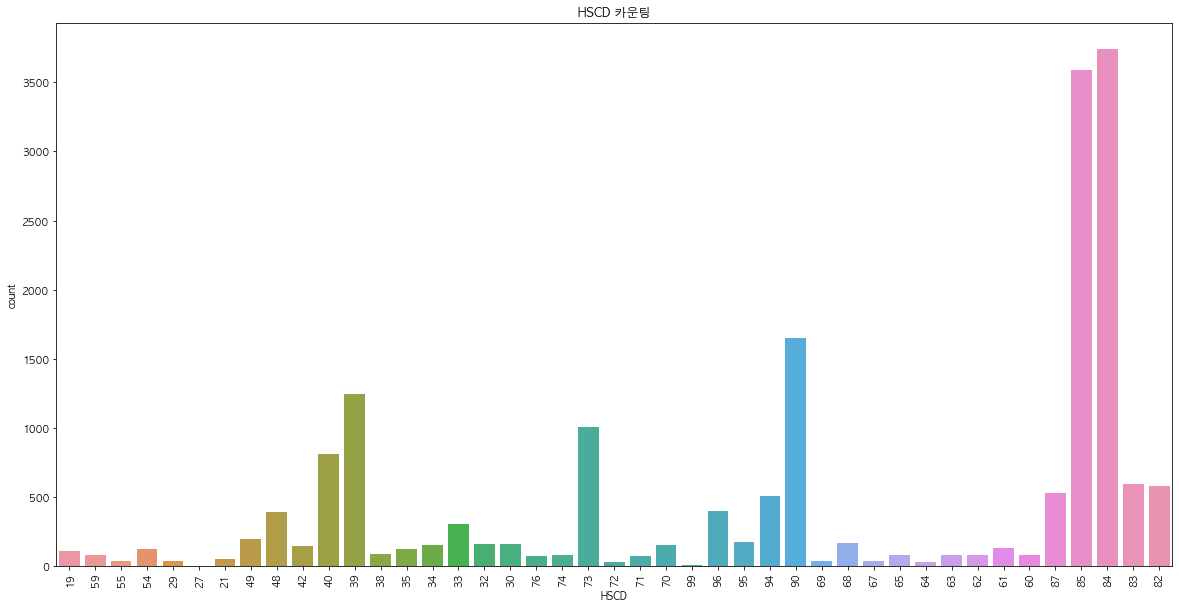

In [196]:
plt.figure(figsize=(20, 10))
sns.countplot(x="HSCD", data=traindata)
plt.xticks(rotation=90)
plt.title("HSCD 카운팅")
plt.show()

- 가장 높은 HSCD 84,85,90,39,73

In [197]:
hs_84 = traindata[traindata['HSCD']=='84']

In [198]:
hs_84['COUNTRYNM'].value_counts() 

Mongolia                104
Kazakhstan              104
Chile                   103
Peru                    103
Egypt                   103
Norway                  102
South Africa            102
New Zealand             102
Kuwait                  102
Philippines             101
Myanmar                 101
Saudi Arabia             99
Viet Nam                 98
Indonesia                98
Malaysia                 97
Iran                     97
Switzerland              97
United Arab Emirates     95
Algeria                  93
Sri Lanka                93
Brazil                   93
Austria                  93
Poland                   91
China, Hong Kong SAR     91
Turkey                   91
Australia                90
Czechia                  90
Singapore                89
India                    89
Russian Federation       88
Spain                    87
Belgium                  81
Guatemala                81
Netherlands              81
Italy                    74
Canada              

In [199]:
hs_85 = traindata[traindata['HSCD']=='85']

In [200]:
hs_85['COUNTRYNM'].value_counts() 

Norway                  101
New Zealand             101
Kazakhstan              101
Chile                   100
South Africa            100
Peru                    100
Mongolia                 98
Switzerland              98
Kuwait                   98
Saudi Arabia             97
Egypt                    96
Indonesia                96
Turkey                   96
Philippines              94
Australia                92
United Arab Emirates     91
Brazil                   91
Austria                  91
Russian Federation       91
Spain                    91
Belgium                  90
Myanmar                  90
Malaysia                 88
Iran                     87
Poland                   85
Viet Nam                 84
Singapore                83
India                    83
Italy                    83
Czechia                  80
Canada                   80
Netherlands              78
Sri Lanka                76
United Kingdom           70
France                   70
Algeria             

In [201]:
hs_90 = traindata[traindata['HSCD']=='90']

In [202]:
hs_90['COUNTRYNM'].value_counts() 

Norway                  43
Philippines             43
Kuwait                  43
Malaysia                43
Kazakhstan              43
Czechia                 43
Chile                   43
New Zealand             43
United Arab Emirates    43
Egypt                   43
Indonesia               43
South Africa            43
Peru                    42
Mongolia                42
Myanmar                 42
Saudi Arabia            42
Australia               42
Austria                 42
Russian Federation      42
Brazil                  41
Poland                  41
Viet Nam                41
Turkey                  41
Iran                    40
Spain                   40
Singapore               40
India                   39
Switzerland             39
Mexico                  39
Italy                   38
Canada                  38
China, Hong Kong SAR    38
Belgium                 38
Netherlands             35
Algeria                 35
United Kingdom          35
France                  33
S

In [203]:
hs_39 = traindata[traindata['HSCD']=='39']

In [204]:
hs_39['COUNTRYNM'].value_counts() 

New Zealand             35
Saudi Arabia            35
Philippines             35
South Africa            35
Chile                   35
Mongolia                35
Egypt                   34
Kazakhstan              34
Switzerland             34
Myanmar                 34
United Arab Emirates    34
Austria                 34
Peru                    34
Czechia                 33
Australia               33
Russian Federation      33
Kuwait                  33
Brazil                  33
China, Hong Kong SAR    32
Iran                    32
Japan                   31
Malaysia                31
Singapore               31
Sri Lanka               30
Spain                   30
Indonesia               30
Norway                  30
India                   29
Viet Nam                29
Turkey                  29
Guatemala               28
Netherlands             27
Poland                  27
Algeria                 26
Italy                   25
Belgium                 22
Canada                  20
U

In [205]:
hs_73 = traindata[traindata['HSCD']=='73']

In [206]:
hs_73['COUNTRYNM'].value_counts()

Indonesia               26
Brazil                  26
South Africa            26
New Zealand             26
Philippines             26
Peru                    26
Kazakhstan              26
Myanmar                 26
Chile                   26
Viet Nam                25
Saudi Arabia            25
Poland                  25
Spain                   25
Malaysia                25
Singapore               25
Kuwait                  25
United Arab Emirates    25
Mongolia                25
Australia               24
Belgium                 24
Czechia                 24
Egypt                   24
Italy                   24
Russian Federation      24
Austria                 24
Turkey                  24
China, Hong Kong SAR    24
Netherlands             23
Canada                  23
Japan                   23
India                   23
Switzerland             23
France                  23
United Kingdom          23
Norway                  23
Mexico                  22
China                   22
I

In [207]:
train[train['HSCD']==854470].sort_values(by='COUNTRYNM', ascending=False).shape[0]

41

In [208]:
hs_85['HSCD'].value_counts() 

85    3588
Name: HSCD, dtype: int64

854470,
       854449, 854442, 854430, 854420, 854390, 854370, 854239, 854232,
       854231, 854140, 854129, 854110, 853949, 853929, 853922, 853921,
       853890, 853810, 853710, 853690, 853670, 853669, 853650, 853649,
       853641, 853630, 853620, 853610, 853590, 853400, 853340, 853329,
       853229, 853190, 853180, 853120, 853110, 852990, 852910, 852872,
       852871, 852869, 852859, 852721, 852692, 852691, 852580, 852352,
       852351, 852349, 852290, 852190, 851890, 851840, 851830, 851829,
       851821, 851810, 851770, 851769, 851762, 851718, 851712, 851690,
       851680, 851679, 851660, 851650, 851629, 851610, 851590, 851580,
       851310, 851290, 851240, 851230, 851220, 851190, 851180, 851150,
       851140, 851130, 851110, 850980, 850940, 850780, 850760, 850720,
       850710, 850680, 850650, 850590, 850490, 850450, 850440, 850431,
       850300, 850140, 850131, 850120, 850110, 848790, 848490, 848420,
       848410, 848390, 848360, 848350, 848340, 848330, 848320, 848310,
       848299, 848280, 848250, 848240, 848220, 848210, 848190, 848180,
       848140, 848130, 848120, 848110, 847990, 847989, 847982, 847790,
       847340, 847330, 847290, 847190, 847180, 847170, 847160, 847150,
       847149, 847141, 847130, 846799, 846729, 846721, 846693, 845090,
       845020, 845011, 844399, 844339, 844332, 844331, 843149, 843143,
       843141, 843139, 843131, 843120, 842952, 842890, 842720, 842549,
       842490, 842489, 842420, 842381, 842290, 842240, 842199, 842139,
       842131, 842129, 842123, 842121, 842119, 841990, 841989, 841950,
       841899, 841869, 841821, 841810, 841590, 841582, 841510, 841490,
       841480, 841459, 841451, 841430, 841410, 841391, 841381, 841370,
       841360, 841350, 841330, 841320, 841319, 841290, 841229, 841221,
       840999, 840991, 840890, 840820, 840734,

In [209]:
#문자형으로 바꾸기 
train6['HSCD'] = train6['HSCD'].astype(str)

In [210]:
#HSCD 변수 생성
#HSCD에 '84' 가 포함되어 있는 행 뽑기 
hs_84_tr = train6[train6['HSCD'].str.contains('84')]
#HSCD에 '84' 가 포함되어 있는 행을 중복 없이 리스트에 저장
hs_84_n = list(hs_84_tr['HSCD'].unique())

#HSCD에 '85' 가 포함되어 있는 행 뽑기 
hs_85_tr = train6[train6['HSCD'].str.contains('85')]
#HSCD에 '85' 가 포함되어 있는 행을 중복 없이 리스트에 저장
hs_85_n = list(hs_85_tr['HSCD'].unique())

#HSCD에 '90' 가 포함되어 있는 행 뽑기 
hs_90_tr = train6[train6['HSCD'].str.contains('90')]
#HSCD에 '90' 가 포함되어 있는 행을 중복 없이 리스트에 저장
hs_90_n = list(hs_90_tr['HSCD'].unique())

#HSCD에 '39' 가 포함되어 있는 행 뽑기 
hs_39_tr = train6[train6['HSCD'].str.contains('39')]
#HSCD에 '39' 가 포함되어 있는 행을 중복 없이 리스트에 저장
hs_39_n = list(hs_39_tr['HSCD'].unique())

#HSCD에 '73' 가 포함되어 있는 행 뽑기 
hs_73_tr = train6[train6['HSCD'].str.contains('73')]
#HSCD에 '73' 가 포함되어 있는 행을 중복 없이 리스트에 저장
hs_73_n = list(hs_73_tr['HSCD'].unique())

#'84,85,90,39,73' 구분 함수
def hscd(x):
    #highschool 리스트에 HSCD 포함되어 있다면 1을 변환
    if x in hs_84_n:
        return 1
    #university 리스트에 HSCD 포함되어 있다면 1을 반환
    elif x in hs_85_n:
        return 1
    elif x in hs_90_n:
        return 1
    elif x in hs_39_n:
        return 1
    elif x in hs_73_n:
        return 1
    #포함되지 않는 HSCD이라면 0을 반환
    else:
        return 0
    
#모든 HSCD 적용
train6['HSCD'] = train6['HSCD'].apply(hscd)

# 5.최종 데이터 프레임정리완료

In [212]:
train6.to_csv('train6.csv',index=False)